# Imports and Settings

In [39]:
import pandas as pd
import os
from typing import List
from typing import Optional
from typing import Dict
from typing import Tuple
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedKFold
from catboost import Pool
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

In [25]:
# Создаём внутренние папки проекта
folders = ['prepared_data', 'catboost_models']

for folder in folders:
    os.makedirs(folder, exist_ok=True) 

In [2]:
# Настройка pandas 
# Показывать все столбцы
pd.set_option('display.max_columns', None)
# Отображать полный текст в ячейках столбцов без усечения
pd.set_option('display.max_colwidth', None)

# Functions

## Functions for assembling a dataset from parquet files

In [3]:
def read_parquet_dataset_from_local(
    path_to_dataset: str,
    start_from: int = 0,
    num_parts_to_read: int = 2,
    columns: Optional[List[str]] = None,
    verbose: bool = False
) -> pd.DataFrame:
    """
    Читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает.

    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :param verbose: выводить ли дополнительную информацию
    :return: pd.DataFrame
    """
    res = []
    dataset_paths = sorted(
        os.path.join(path_to_dataset, filename)
        for filename in os.listdir(path_to_dataset)
        if filename.startswith('train')
    )

    if verbose:
        print('Dataset paths:')
        for path in dataset_paths:
            print(path)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]

    if verbose:
        print('Reading chunks:')
        for chunk in chunks:
            print(chunk)

    for chunk_path in tqdm(chunks, desc="Reading dataset with pandas"):
        if verbose:
            print('Reading chunk:', chunk_path)
        chunk = pd.read_parquet(chunk_path, columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

In [4]:
def prepare_transactions_dataset(
    path_to_dataset: str,
    num_parts_to_preprocess_at_once: int = 1,
    num_parts_total: int = 50,
    save_to_path: str = None,
    verbose: bool = False
) -> pd.DataFrame:
    """
    Возвращает исходный pd.DataFrame с признаками из которых нужно собрать
    учебный датасет.

    :param path_to_dataset:
        путь до датасета с партициями
    :param num_parts_to_preprocess_at_once:
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    :param num_parts_total:
        общее количество партиций, которые нужно обработать
    :param save_to_path: 
        путь до папки для сохранения обработанных блоков в .parquet-формате; если None, сохранение не происходит
    :param verbose: 
        логировать каждую обрабатываемую часть данных
    :return: pd.DataFrame с объединёнными данными
    """
    preprocessed_frames = []

    for step in tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                     desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(
            path_to_dataset,
            start_from=step,
            num_parts_to_read=num_parts_to_preprocess_at_once,
            verbose=verbose
        )

       # Записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    
    return pd.concat(preprocessed_frames)

## Feature engineering functions

In [4]:
def create_rn_max_feature(
    df_source: pd.DataFrame, 
    df_to_update: pd.DataFrame
) -> pd.DataFrame:
    '''
    Добавляет в df_to_update новую колонку 'rn_max', 
    содержащую максимальное значение 'rn' для каждого 'id' из df_source.

    Параметры:
    df_source (pd.DataFrame): исходный DataFrame с колонками 'id' и 'rn'.
    df_to_update (pd.DataFrame): DataFrame, в который добавляется новая колонка.

    Возвращает:
    pd.DataFrame: обновлённый df_to_update с колонкой 'rn_max'.
    '''    
    # Группируем df_source по 'id' и вычисляем максимальное значение 'rn' для каждой группы
    rn_max = (
    df_source
    .groupby('id', as_index=False)['rn']
    .max()
    .rename(columns={'rn': 'rn_max'})
    )

    # Объединяем df_to_update с результатом группировки по колонке 'id'
    df_to_update = df_to_update.merge(rn_max, on='id', how='left') 
    
    return df_to_update

In [5]:
def create_all_value_proportion_features(
    df_source: pd.DataFrame,
    df_to_update: pd.DataFrame,
    column: str
) -> Tuple[pd.DataFrame, List[str]]:
    '''
    Для каждого уникального значения признака column
    функция создаёт новые числовые признаки,
    отражающие долю кредитов клиента (id), в которых это значение встречается.

    Аргументы:
    df_source : исходный датафрейм.
    df_to_update : целевой датафрейм, к которому добавляются новые признаки.
    column : имя столбца, по уникальным значениям которого создаются признаки.
    
    Возвращает:
    df_to_update : обновлённый датафрейм с добавленными признаками.
    new_features_list : список имён новых признаков.
    '''
    new_features_list = []

    for value in sorted(df_source[column].unique()):
        new_column = f'{column}_prop_{value}'
        new_features_list.append(new_column)

        # Группируем по 'id' количество записей с текущим значением признака
        group_value = (
            df_source[df_source[column] == value]
            .groupby('id')
            .size()
            .rename(new_column)
        )

        # Объединяем с целевым датафреймом по ключу 'id'
        df_to_update = df_to_update.merge(group_value, on='id', how='left')

        # Заполняем пропуски нулями (отсутствие записей с данным значением)
        df_to_update[new_column] = df_to_update[new_column].fillna(0)

        # Вычисляем долю записей с этим значением относительно количества кредитов клиента
        df_to_update[new_column] = df_to_update[new_column] / df_to_update['rn_max']

    return df_to_update, new_features_list

In [6]:
def choose_n_most_imp_features(
    df_train: pd.DataFrame,
    new_features_list: List[str],
    n_features: int
) -> List[int]:
    '''
    Функция принимает тренировочный датафрейм и создаёт его урезанную версию 
    со столбцами из new_features_list. 
    На ней обучает CatBoostClassifier с 5-кратной стратифицированной кросс-валидацией,
    собирает важности признаков и вычисляет средние метрики ROC AUC.

    Возвращает список числовых значений, извлечённых из имён "n_features" наиболее важных признаков.

    Аргументы:
        df_train : тренировочный датафрейм с признаками и целевой переменной 'flag'.
        new_features_list : список имён новых признаков для оценки.
        n_features : количество признаков для выбора.

    Возвращает:
        List: список числовых значений, извлечённых из имён "n_features" наиболее важных признаков.
    '''
    # Выбираем целевую переменную и признаки
    X = df_train[new_features_list]
    y = df_train['flag']    

    # Создадим списки для хранения ROC AUC по фолдам
    roc_auc_scores_train = []
    roc_auc_scores_val = []

    # Создадим словарь для накопления важностей признаков на каждом фолде
    importances_dict = {col: [] for col in X.columns}

    # Инициализируем стратифицированный KFold
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Поделим данные на train/val
    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Упакуем результат в Pool
        train_pool = Pool(data=X_train, label=y_train)
        val_pool = Pool(data=X_val, label=y_val)

        # Обучим модель CatBoost
        model = CatBoostClassifier(
            early_stopping_rounds=100,
            eval_metric='AUC',
            random_seed=0,
            verbose=False,
            thread_count=-1,
            auto_class_weights='Balanced'
        )
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True
        )

        # Сохраним важности признаков в словарь
        importances = model.get_feature_importance()
        for col, imp in zip(X.columns, importances):
            importances_dict[col].append(imp)

        # Предскажем вероятности и оценим ROC AUC
        train_pred_proba = model.predict_proba(X_train)[:, 1]
        val_pred_proba = model.predict_proba(X_val)[:, 1]

        roc_auc_scores_train.append(roc_auc_score(y_train, train_pred_proba))
        roc_auc_scores_val.append(roc_auc_score(y_val, val_pred_proba))

    # Выведем средние и стандартные отклонения ROC AUC по фолдам
    print(f'Среднее ROC AUC на трейне: {np.mean(roc_auc_scores_train):.4f}')
    print(f'Стандартное отклонение ROC AUC на трейне: {np.std(roc_auc_scores_train):.4f}')
    print(f'Среднее ROC AUC на валидации: {np.mean(roc_auc_scores_val):.4f}')
    print(f'Стандартное отклонение ROC AUC на валидации: {np.std(roc_auc_scores_val):.4f}')

    # Выведем медианные важности признаков как более устойчивые к выбросам
    median_importances = {col: np.median(imps) for col, imps in importances_dict.items()}

    # Отсортируем признаки по убыванию важности  
    sorted_features = sorted(median_importances.items(), key=lambda x: x[1], reverse=True)

    # Выберем n_features наиболее важных признаков
    most_imp_features = [feat for feat, _ in sorted_features[:n_features]]

    # Извлечем числовые значения из имён признаков (число после последнего '_')
    values = [int(feature.rsplit('_', 1)[-1]) for feature in most_imp_features]

    return values

In [40]:
def create_definite_value_proportion_features(
    df_source: pd.DataFrame,
    df_to_update: pd.DataFrame,
    features_dictionary: Dict[str, List]
) -> pd.DataFrame:
    '''
    На основе заданных словарём признаков и их значений функция создаёт новые числовые признаки,
    отражающие долю кредитов клиента (id), в которых это значение встречается. 
    Новые признаки добавляются в целевой датафрейм

    Аргументы:
        df_source : исходный датафрейм.
        df_to_update : датафрейм, в который добавляются новые признаки.
        features_dictionary : словарь, где ключи — имена столбцов исходного датафрейма,
            а значения — списки значений, по которым создаются признаки.

    Возвращает:
        pd.DataFrame: обновлённый датафрейм с добавленными частотными признаками.
    '''
    for col in features_dictionary.keys():
        print('Исходный признак:', col)
        print('Новые фичи:')

        for value in features_dictionary[col]:
            new_column = f'{col}_prop_{value}'
            print(new_column)

            # Фильтруем df_source по текущему значению и считаем количество записей для каждого id
            group_value = (
                df_source[df_source[col] == value]
                .groupby('id')
                .size()
                .rename(new_column)
            )

            # Объединяем с целевым датафреймом по ключу 'id'
            df_to_update = df_to_update.merge(group_value, on='id', how='left')

            # Заполняем пропуски нулями (отсутствие записей с данным значением)
            df_to_update[new_column] = df_to_update[new_column].fillna(0)

            # Вычисляем долю записей с этим значением относительно общего количества кредитов клиента
            df_to_update[new_column] = df_to_update[new_column] / df_to_update['rn_max']

    return df_to_update

# Description of dataset

In [3]:
# Описание признаков датасета
df_schema = pd.read_excel('description.xlsx', sheet_name='features')
df_schema

,Поле,Описание
0,id,"Идентификатор заявки. Заявки пронумерованы так, что большему номеру соответствует более поздняя дата заявки."
1,rn,Порядковый номер кредитного продукта в кредитной истории. Большему номеру соответствует продукт с более поздней датой открытия.
2,pre_since_opened,Дней с даты открытия кредита до даты сбора данных (бинаризовано*)
3,pre_since_confirmed,Дней с даты подтверждения информации по кредиту до даты сбора данных (бинаризовано*)
4,pre_pterm,Плановое количество дней с даты открытия кредита до даты закрытия (бинаризовано*)
5,pre_fterm,Фактическое количество дней с даты открытия кредита до даты закрытия (бинаризовано*)
6,pre_till_pclose,Плановое количество дней с даты сбора данных до даты закрытия кредита (бинаризовано*)
7,pre_till_fclose,Фактическое количество дней с даты сбора данных до даты закрытия кредита (бинаризовано*)
8,pre_loans_credit_limit,Кредитный лимит (бинаризовано*)
9,pre_loans_next_pay_summ,Сумма следующего платежа по кредиту (бинаризовано*)


# Target

In [7]:
# Загрузим датасет с целевой переменной
df_target = pd.read_csv('train_target.csv')
df_target

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2999995,2999995,0
2999996,2999996,0
2999997,2999997,0
2999998,2999998,0


In [12]:
# Проверим на пустые значения
print('Количество пустых строк',
df_target[df_target.isnull().any(axis=1)].shape[0])

Количество пустых строк 0


In [13]:
# Проверим на дубликаты строк
print('Количество дубликатов строк',
df_target[df_target.duplicated()].shape[0])

Количество дубликатов строк 0


In [14]:
df_target.dtypes

id      int64
flag    int64
dtype: object

In [15]:
# Проверим на монотонное возрастание id
print('id возростает монотонно',
df_target['id'].is_monotonic_increasing)

id возростает монотонно True


In [16]:
# Вычислим коэффициент дисбаланса
print('Коэффициент дисбаланса', 
df_target[df_target.flag == 0].shape[0] / df_target[df_target.flag == 1].shape[0])

Коэффициент дисбаланса 27.18436331523271


Выводы.    
Дубликатов и пустых значений нет, типы данных правильные, id идёт по порядку возрастания.  
Датасет перекошен в 27 раз сторону класса 0.

# Assemble the source dataset from parquet files

In [5]:
# Путь до исходных данных на компьютере
path = 'train_data/'

In [6]:
# Исходный данные находятся в двенадцати файлах parquet
df = prepare_transactions_dataset(
    path,
    num_parts_to_preprocess_at_once=1,
    num_parts_total=12,
    save_to_path='train_data/')

Transforming transactions data:   0%|          | 0/12 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,pre_util,pre_over2limit,pre_maxover2limit,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,enc_paym_8,enc_paym_9,enc_paym_10,enc_paym_11,enc_paym_12,enc_paym_13,enc_paym_14,enc_paym_15,enc_paym_16,enc_paym_17,enc_paym_18,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,3,0,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,3,0,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,5,0,2,8,6,16,5,4,8,1,1,1,1,1,15,2,17,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,3,0,2,4,6,16,5,4,8,0,1,1,1,1,16,2,17,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,3,0,2,4,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,0,0,0,0,0,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2284251,2499999,11,3,9,4,3,1,12,6,2,3,0,2,7,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1,1,0
2284252,2499999,12,3,9,1,15,12,6,9,3,3,0,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,4,3,3,3,4,1,3,4,1,0,0
2284253,2499999,13,2,9,4,8,1,11,7,3,5,0,1,5,6,16,5,4,8,1,0,1,1,1,1,2,3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2,1,1,1,0,3,3,3,3,4,3,3,3,4,1,2,3,1,1,1
2284254,2499999,14,2,9,4,9,1,15,16,2,3,0,1,2,6,16,5,4,8,1,0,1,1,1,16,2,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1,1,0


In [13]:
print('Количество уникальных id',
f'{df.id.nunique():,}')

Количество уникальных id 3,000,000


In [14]:
# Проверим на пустые значения
print('Количество пустых строк',
df[df.isnull().any(axis=1)].shape[0])

Количество пустых строк 0


In [15]:
# Проверим на дубликаты строк
print('Количество дубликатов строк',
df[df.duplicated()].shape[0])

Количество дубликатов строк 0


In [22]:
df.dtypes.tolist()

[dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'

In [18]:
# Проверим на монотонное возрастание id
print('id возростает монотонно',
df['id'].is_monotonic_increasing)

id возростает монотонно False


In [19]:
# Пусть id и rn идут по возрастанию
df.sort_values(by=['id', 'rn'], ignore_index=True, inplace=True)

print('id возростает монотонно',
df['id'].is_monotonic_increasing)

id возростает монотонно True


In [21]:
# Проверим на монотонное возрастание и уникальность индексов
print('Индекс возрастает монотонно', 
df.index.is_monotonic_increasing)

print('Индексы уникальны',
df.index.is_unique)

Индекс возрастает монотонно True
Индексы уникальны True


In [26]:
# Запишем исходный датасет в файл
df.to_csv('prepared_data/source_data.csv', index=False)

# Create train/test datasets, split sourse dataset

Разделим таргет датасет на тренировочную и тестовую часть и создадим df_train/df_test,    
датасет с исходными данными поделим на source_df_train/source_df_test     
соответсвенно id в df_train/df_test.    
В df_train/df_test будем набирать фичи через агрегирование признаков в source_df_train/source_df_test.

In [51]:
# Разделим  таргет датасет на тренировочную и тестовую подвыборки
df_train, df_test  = train_test_split(
    df_target,
    train_size=0.8,
    random_state=0,
    stratify=df_target.flag
)
df_train.shape, df_test.shape

((2400000, 2), (600000, 2))

In [52]:
# Отсортируем результат по id
df_train = df_train.sort_values(by='id').reset_index(drop=True)
df_test = df_test.sort_values(by='id').reset_index(drop=True)

In [10]:
# Выберем id из тренировочной и тестовой подвыборок
train_id = df_train['id'].values
test_id = df_test['id'].values

In [116]:
# Разделим исходный датасет по id на тренировочную и тестовую подвыборки 
source_df_train = df[df['id'].isin(train_id)]
source_df_test = df[df['id'].isin(test_id)]
source_df_train.shape, source_df_test.shape

((20931476, 61), (5231241, 61))

In [53]:
# Проверим что в исходныхм и целевых датасетах наборы id одинаковые
all(df_train.id.unique() == source_df_train.id.unique())

True

In [20]:
all(df_test.id.unique() == source_df_test.id.unique())

True

In [54]:
df_train.head(3)

,id,flag
0,0,0
1,1,0
2,2,0


In [152]:
source_df_train.head(3)

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,pre_util,pre_over2limit,pre_maxover2limit,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,enc_paym_8,enc_paym_9,enc_paym_10,enc_paym_11,enc_paym_12,enc_paym_13,enc_paym_14,enc_paym_15,enc_paym_16,enc_paym_17,enc_paym_18,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,3,0,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,3,0,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,5,0,2,8,6,16,5,4,8,1,1,1,1,1,15,2,17,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,2,3,1,1,1


In [55]:
# Сохраним тренировочную и тестовую подвыборки таргет датасета
df_train.to_csv('prepared_data/features_data_train.csv', index=False)
df_test.to_csv('prepared_data/features_data_test.csv', index=False)

In [45]:
# Сохраним тренировочную и тестовую подвыборки исходного датасета
source_df_train.to_csv('prepared_data/source_data_train.csv', index=False)
source_df_test.to_csv('prepared_data/source_data_test.csv', index=False)

# Feature engineering

## Lists of feature groups

In [27]:
# Группы признаков

# rn - уникальный признак

# Бинаризированные
pre_features = [
    'pre_since_opened',
    'pre_since_confirmed',
    'pre_pterm',
    'pre_fterm',
    'pre_till_pclose',
    'pre_till_fclose',
    'pre_loans_credit_limit',
    'pre_loans_next_pay_summ',
    'pre_loans_outstanding',
    'pre_loans_total_overdue',
    'pre_loans_max_overdue_sum',
    'pre_loans_credit_cost_rate',
    'pre_loans5',
    'pre_loans530',
    'pre_loans3060',
    'pre_loans6090',
    'pre_loans90',
    'pre_util',
    'pre_over2limit',
    'pre_maxover2limit'
]

# Закодированные
enc_features = [
    'enc_loans_account_holder_type',
    'enc_loans_credit_status',
    'enc_loans_credit_type',
    'enc_loans_account_cur'
]

# Статусы ежемесячных платежей
enc_paym_features = [
    'enc_paym_0',
    'enc_paym_1',
    'enc_paym_2',
    'enc_paym_3',
    'enc_paym_4',
    'enc_paym_5',
    'enc_paym_6',
    'enc_paym_7',
    'enc_paym_8',
    'enc_paym_9',
    'enc_paym_10',
    'enc_paym_11',
    'enc_paym_12',
    'enc_paym_13',
    'enc_paym_14',
    'enc_paym_15',
    'enc_paym_16',
    'enc_paym_17',
    'enc_paym_18',
    'enc_paym_19',
    'enc_paym_20',
    'enc_paym_21',
    'enc_paym_22',
    'enc_paym_23',
    'enc_paym_24'
]

#  Флаги
flags_features = [
    'is_zero_loans5',
    'is_zero_loans530',
    'is_zero_loans3060',
    'is_zero_loans6090',
    'is_zero_loans90',
    'is_zero_util',
    'is_zero_over2limit',
    'is_zero_maxover2limit',
    'pclose_flag',
    'fclose_flag'
]

##  From rn create rn_max feature

In [56]:
df_train = pd.read_csv('prepared_data/features_data_train.csv')
df_test = pd.read_csv('prepared_data/features_data_test.csv')
df_train.shape, df_test.shape

((2400000, 2), (600000, 2))

In [19]:
source_df_train = pd.read_csv('prepared_data/source_data_train.csv')
source_df_test = pd.read_csv('prepared_data/source_data_test.csv')
source_df_train.shape, source_df_test.shape

((20931476, 61), (5231241, 61))

In [182]:
df_train

,id,flag
0,0,0
1,1,0
2,2,0
3,4,0
4,5,0
...,...,...
2399995,2999991,0
2399996,2999993,0
2399997,2999995,0
2399998,2999996,0


In [57]:
'''
Добавим в df_train/df_test новую колонку 'rn_max',    
содержащую максимальное значение 'rn' для каждого 'id' из df_source.
'''
df_train = create_rn_max_feature(source_df_train, df_train)
df_test = create_rn_max_feature(source_df_test, df_test)
df_train.shape, df_test.shape

((2400000, 3), (600000, 3))

In [58]:
nan_count = df_train.isna().sum().sum()
print("Количество NaN в df_train:", nan_count)

nan_count = df_test.isna().sum().sum()
print("Количество NaN в df_test:", nan_count)

Количество NaN в df_train: 0
Количество NaN в df_test: 0


In [59]:
# Сохраним промежуточный результат
df_train.to_csv('prepared_data/rn_train.csv', index=False)
df_test.to_csv('prepared_data/rn_test.csv', index=False)

## Pre_features

### Research pre_features

In [56]:
df = pd.read_csv('prepared_data/source_data.csv')
df.shape

(26162717, 61)

In [66]:
source_df_train = pd.read_csv('prepared_data/source_data_train.csv')
source_df_train.shape

(20931476, 61)

In [67]:
source_df_test = pd.read_csv('prepared_data/source_data_test.csv')
source_df_test.shape

(5231241, 61)

In [57]:
# Посмотрим на количество уникальных значений признаков
for col in df[pre_features]:
    print(col, df[col].nunique())

pre_since_opened 20
pre_since_confirmed 18
pre_pterm 18
pre_fterm 17
pre_till_pclose 17
pre_till_fclose 16
pre_loans_credit_limit 20
pre_loans_next_pay_summ 7
pre_loans_outstanding 5
pre_loans_total_overdue 2
pre_loans_max_overdue_sum 4
pre_loans_credit_cost_rate 14
pre_loans5 13
pre_loans530 20
pre_loans3060 10
pre_loans6090 5
pre_loans90 7
pre_util 20
pre_over2limit 20
pre_maxover2limit 20


In [58]:
# Посмотрим на признак с двумя значениями
df.pre_loans_total_overdue.value_counts()

pre_loans_total_overdue
0    26162716
1           1
Name: count, dtype: int64

In [31]:
# Удалим его из списка как неинформативный
pre_features.remove('pre_loans_total_overdue')
pre_features

['pre_since_opened',
 'pre_since_confirmed',
 'pre_pterm',
 'pre_fterm',
 'pre_till_pclose',
 'pre_till_fclose',
 'pre_loans_credit_limit',
 'pre_loans_next_pay_summ',
 'pre_loans_outstanding',
 'pre_loans_max_overdue_sum',
 'pre_loans_credit_cost_rate',
 'pre_loans5',
 'pre_loans530',
 'pre_loans3060',
 'pre_loans6090',
 'pre_loans90',
 'pre_util',
 'pre_over2limit',
 'pre_maxover2limit']

In [60]:
# Посмотрим есть ли различия в уникальных значениях между трен и тест выборками
for col in pre_features:
    if sorted(source_df_train[col].unique()) != sorted(source_df_test[col].unique()):
        print(col, sorted(source_df_train[col].unique()))
        print(col, sorted(source_df_test[col].unique()))

pre_loans_max_overdue_sum [0, 1, 2, 3]
pre_loans_max_overdue_sum [1, 2, 3]
pre_loans5 [0, 1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 16]
pre_loans5 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 13, 16]
pre_loans530 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
pre_loans530 [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19]
pre_loans3060 [0, 1, 2, 3, 5, 6, 7, 8, 9]
pre_loans3060 [1, 2, 4, 5, 6, 7, 8, 9]
pre_loans6090 [1, 2, 3, 4]
pre_loans6090 [0, 1, 2, 3, 4]


В некоторых признаках уникальные значения в тренировочной и тестовой выборках не совпадают,     
что может привести к проблемам с обобщением модели на новых данных.

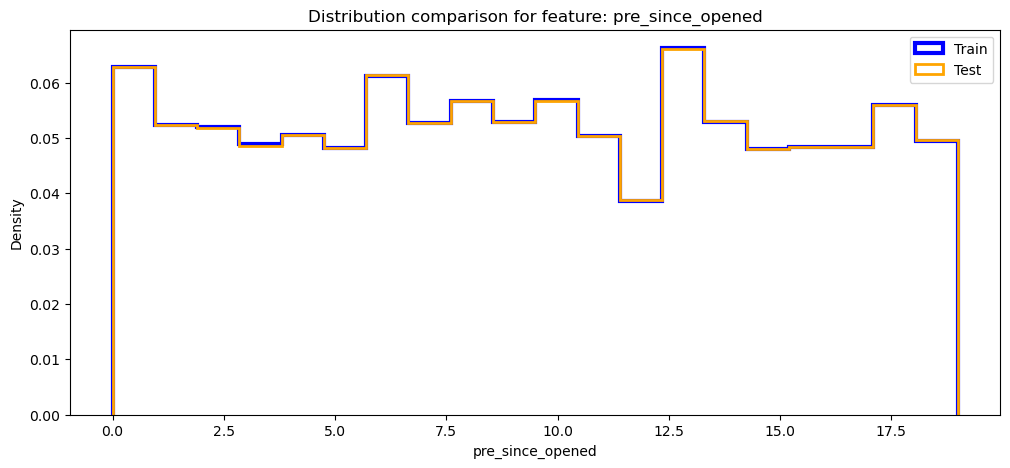

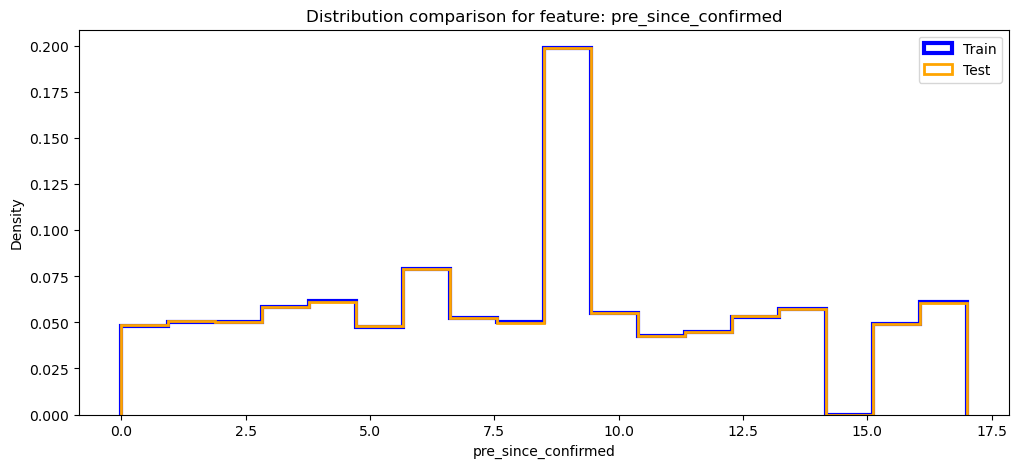

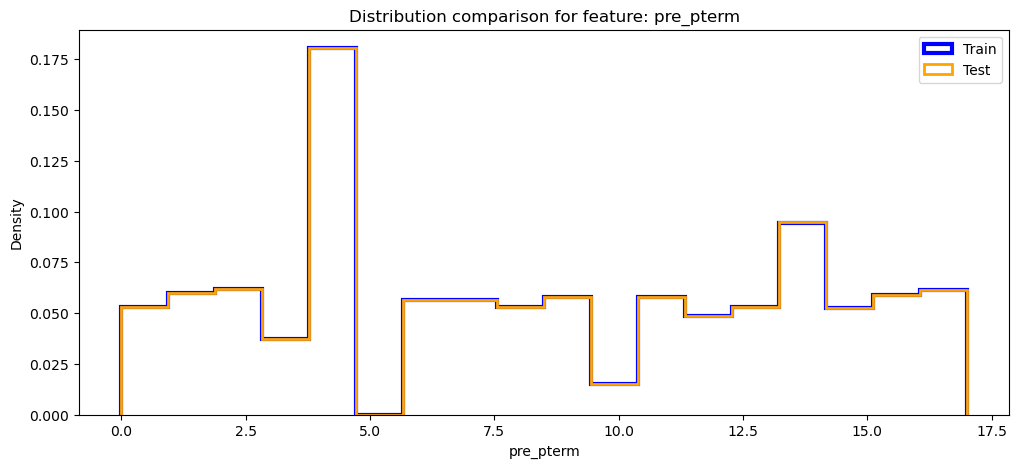

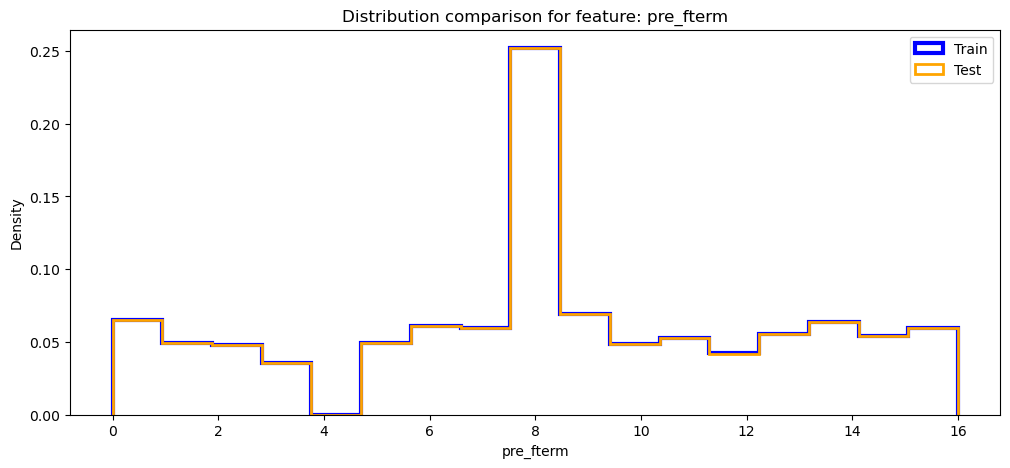

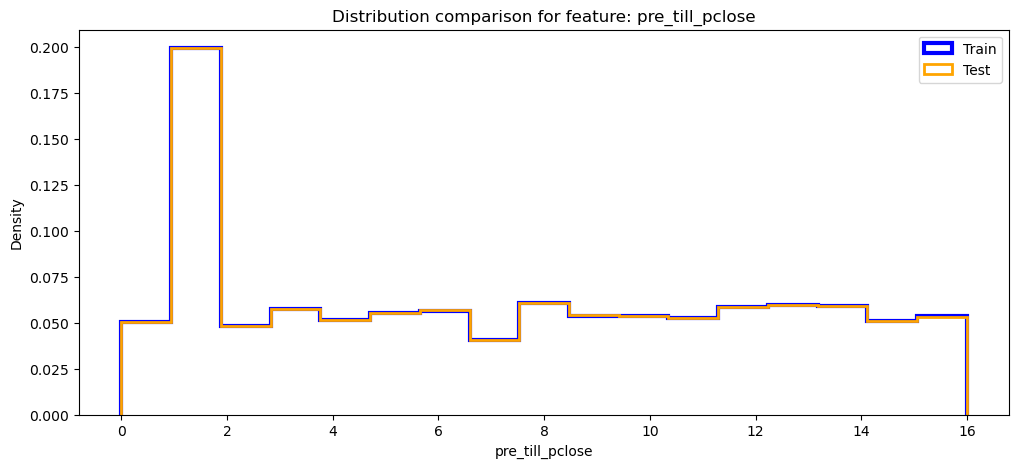

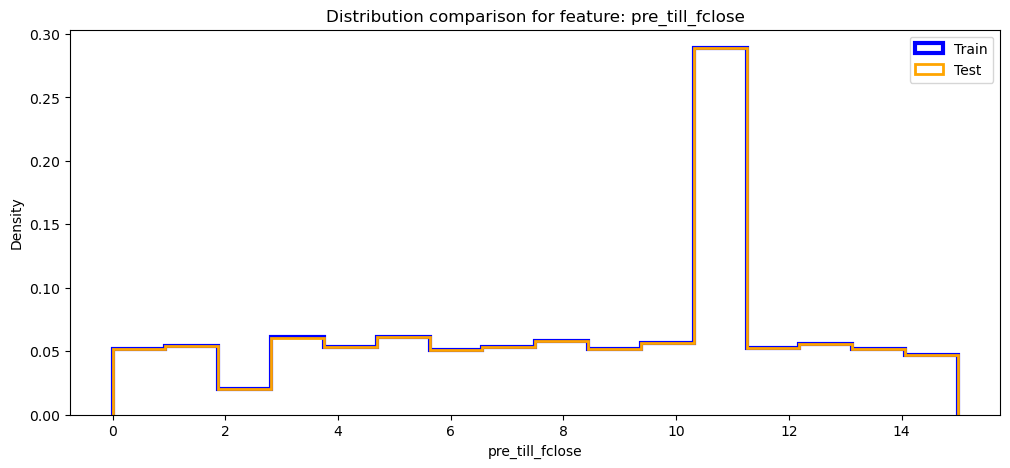

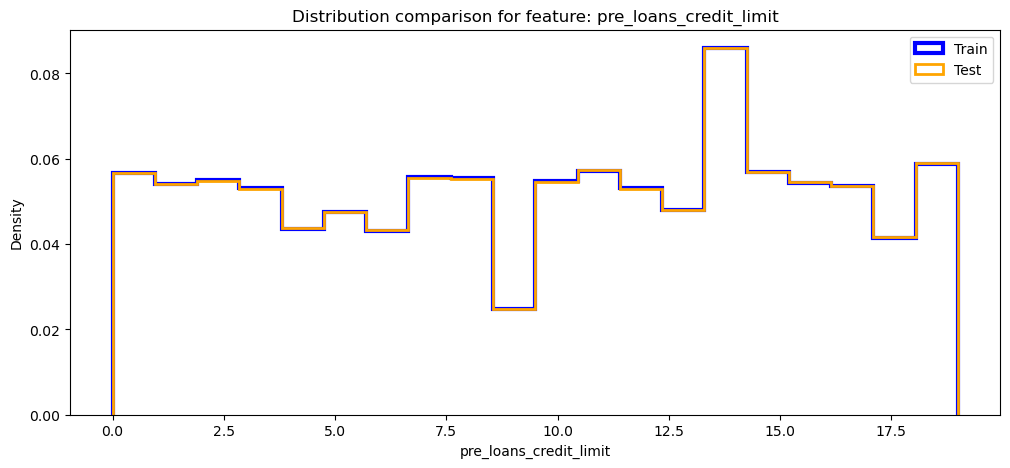

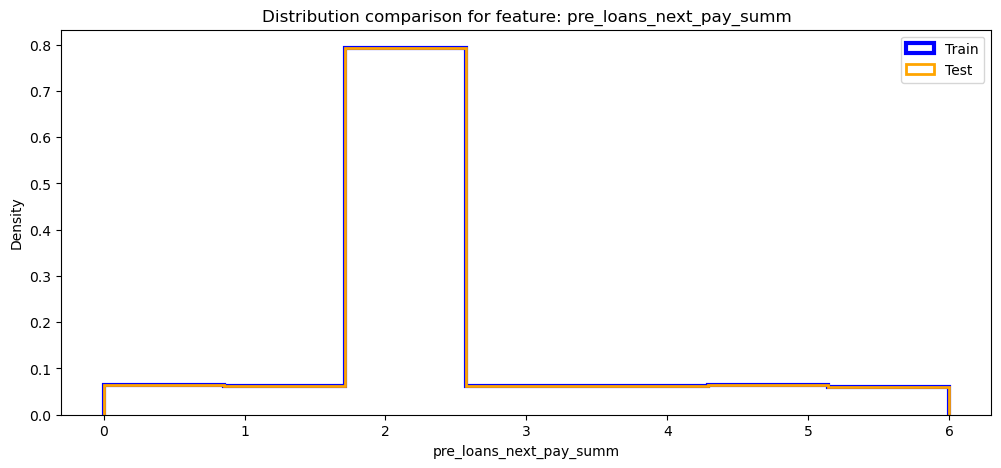

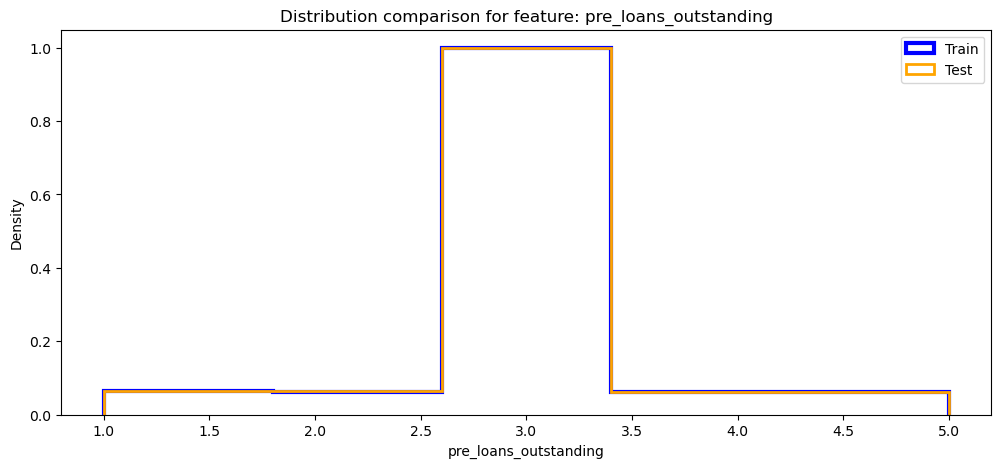

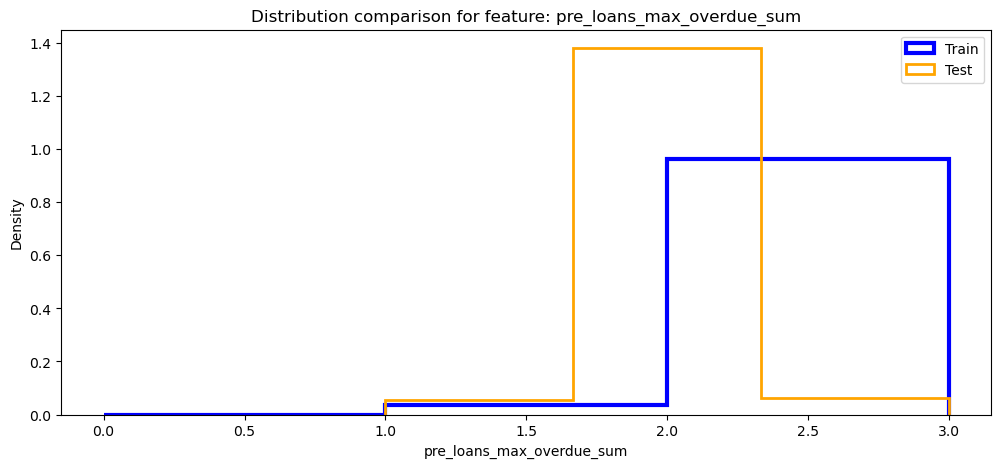

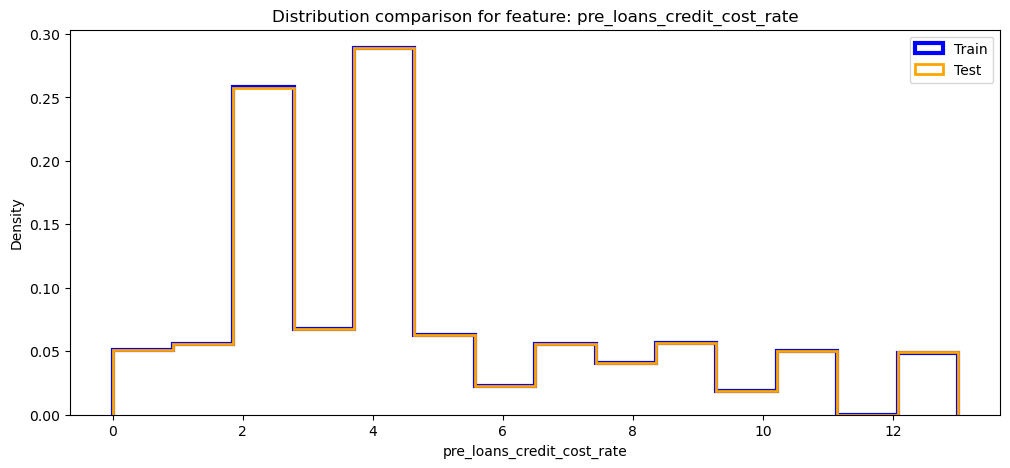

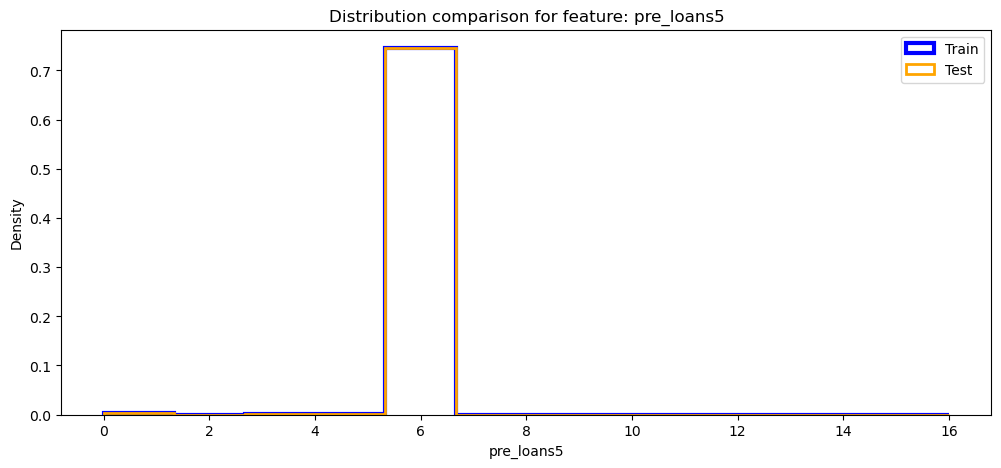

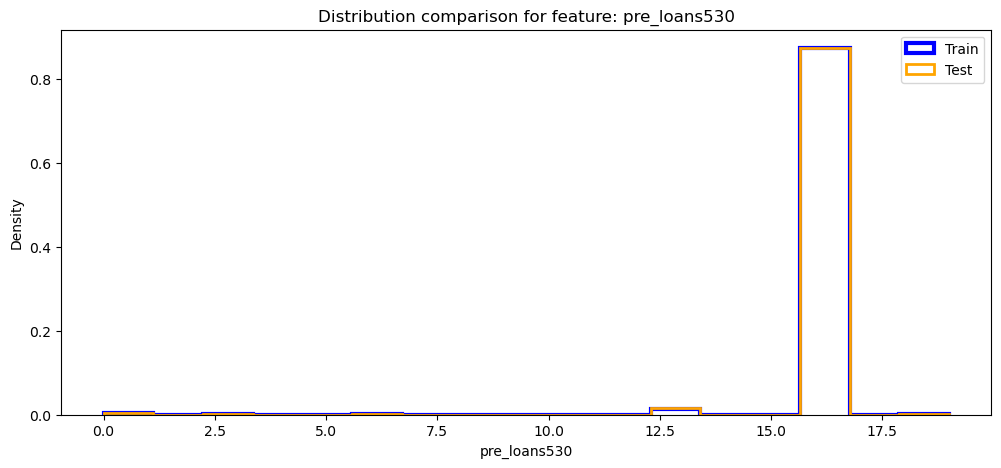

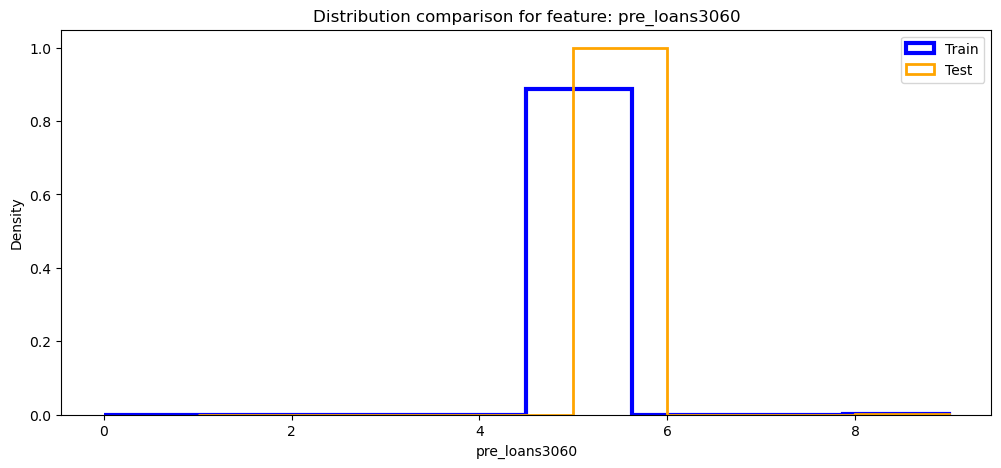

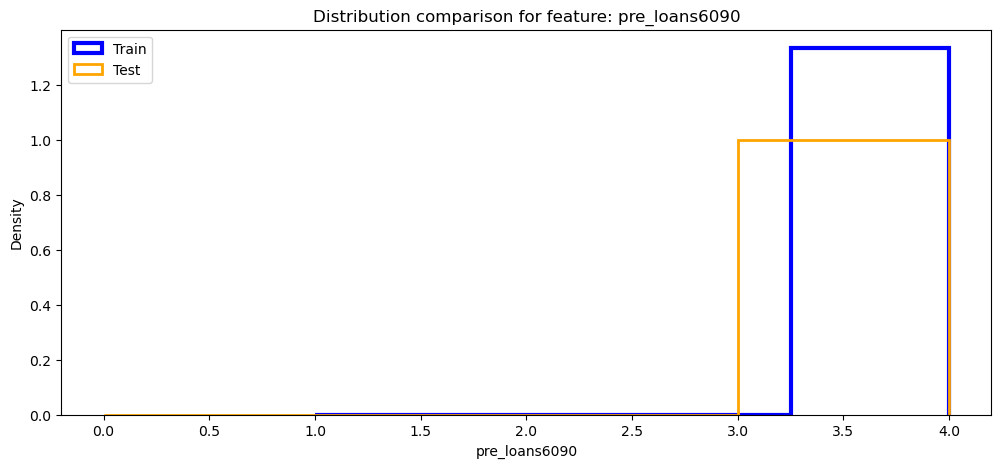

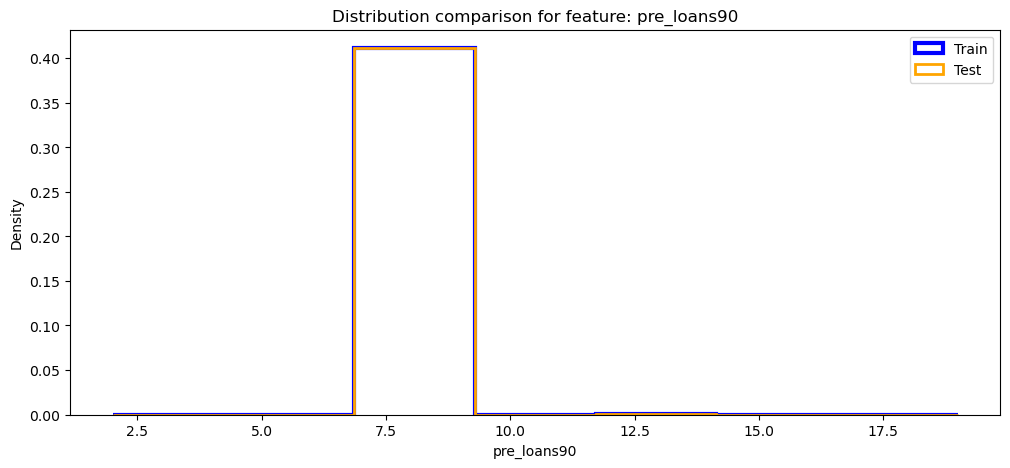

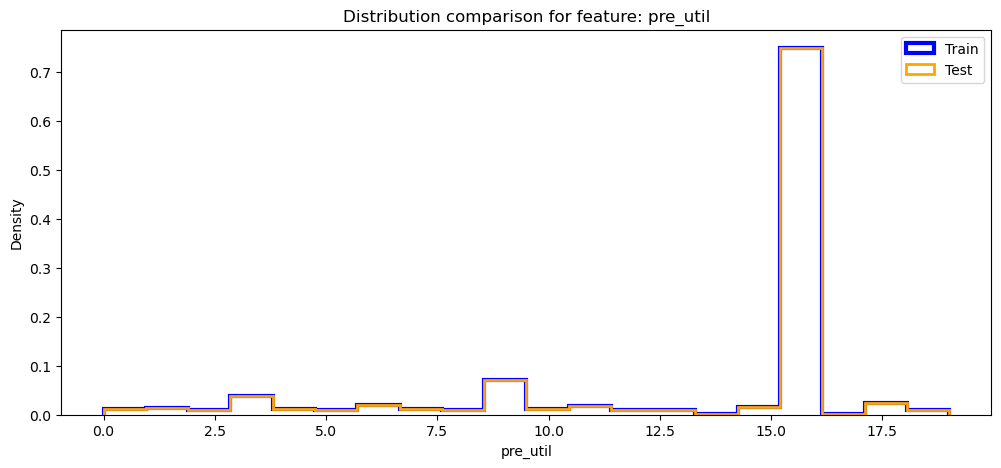

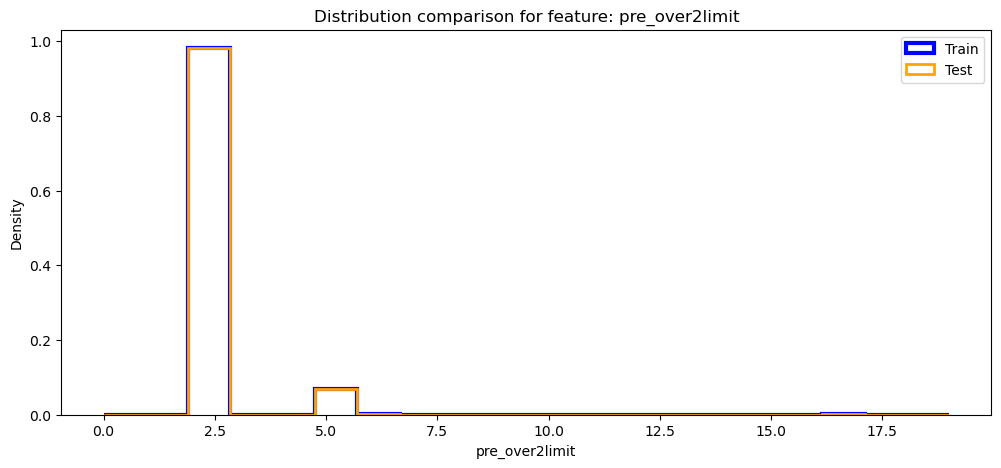

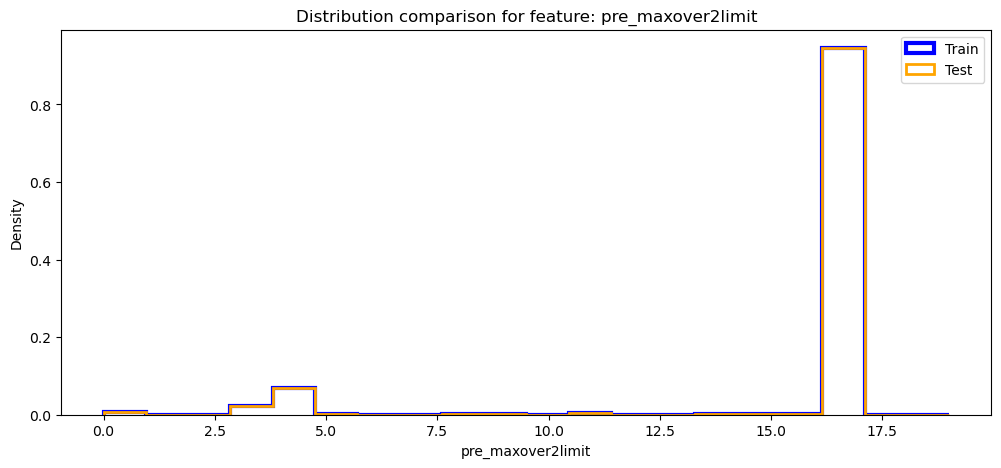

In [84]:
# Визуально сравним распределения признаков для тренировочного и тестового датасетов
for col in pre_features:
    plt.figure(figsize=(12, 5))
    
    # Выбираем количество бинов как минимальное число уникальных значений в train и test
    bins = min(source_df_train[col].nunique(), source_df_test[col].nunique())
    
    # Строим нормализованные гистограммы для тренировочного и тестового наборов
    plt.hist(
        source_df_train[col],
        bins=bins,
        density=True,
        label='Train',
        color='blue',
        histtype='step',
        linewidth=3
    )
    plt.hist(
        source_df_test[col],
        bins=bins,
        density=True,
        label='Test',
        color='orange',
        histtype='step',
        linewidth=2
    )

    plt.title(f'Distribution comparison for feature: {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

Распределения признаков за некоторыми исключениями практически совпадают, что свидетельствует о корректном разбиении данных и отсутствии явного сдвига между выборками.    
Для  признаков  pre_loans_max_overdue_sum, pre_loans3060, pre_loans6090  различия распределений  между train и test связаны со слегка отличающимися наборами уникальных данных.

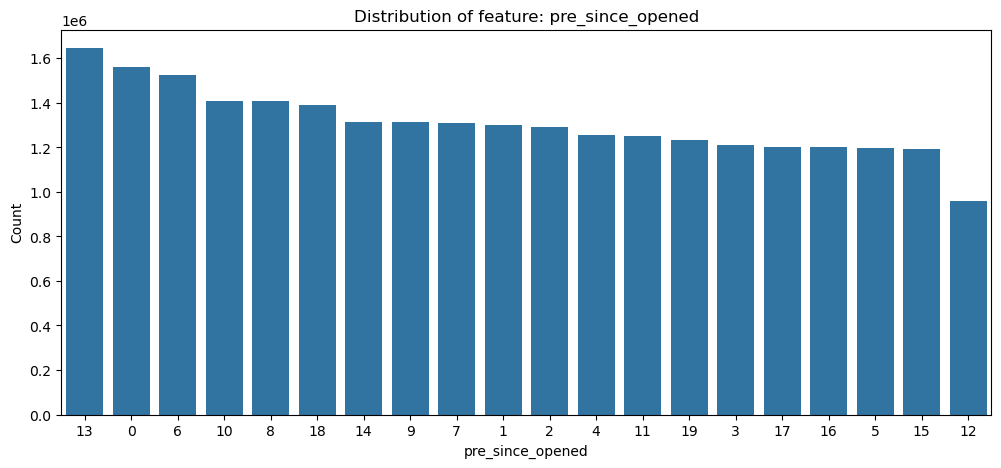

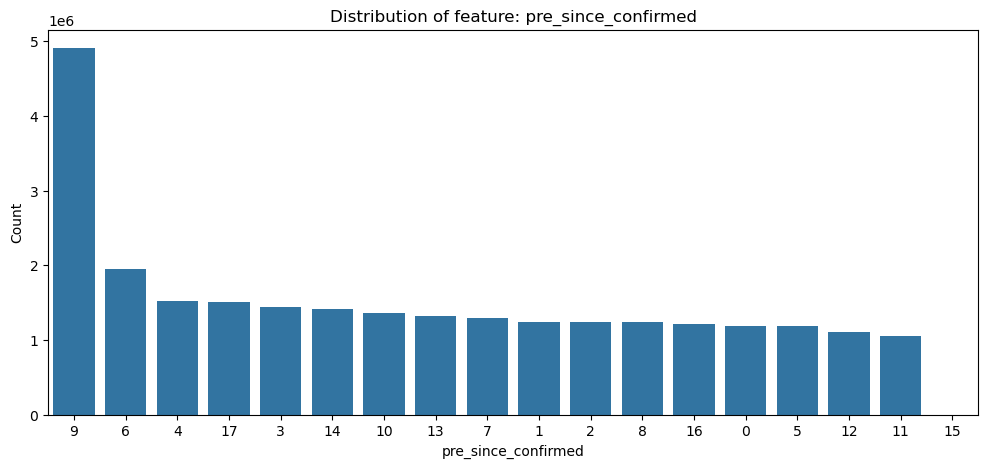

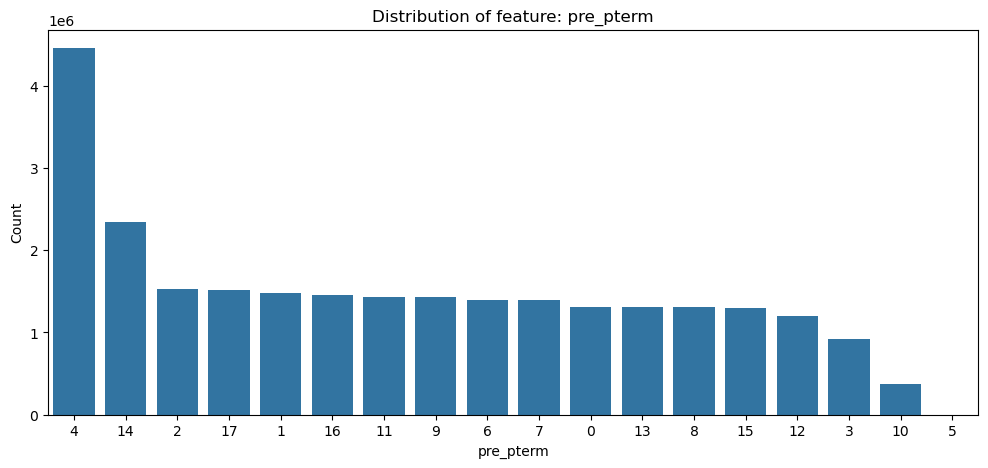

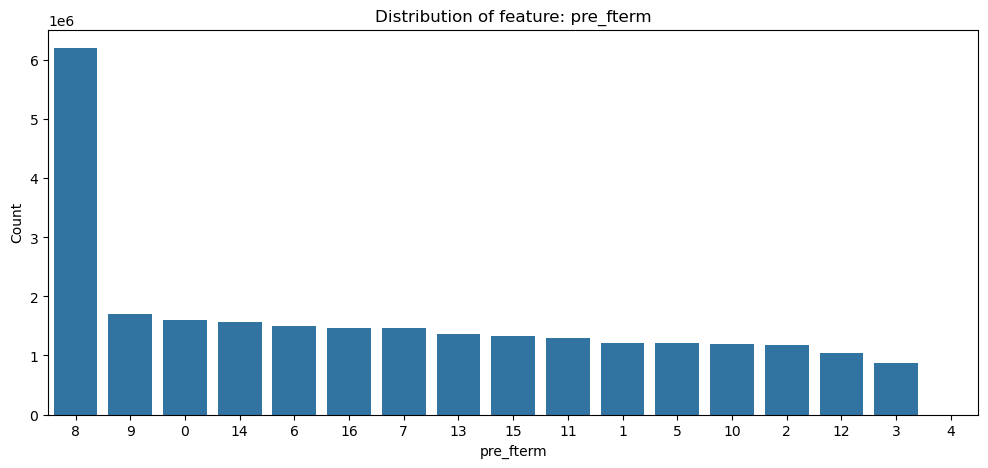

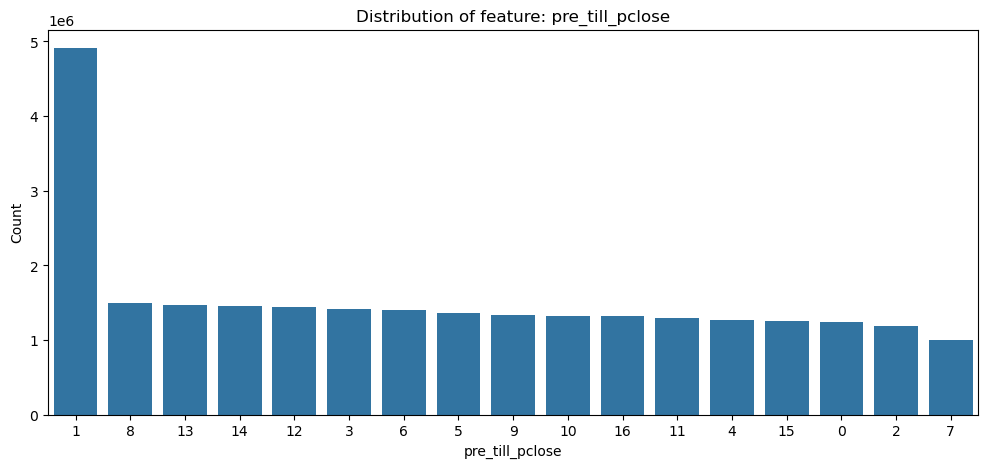

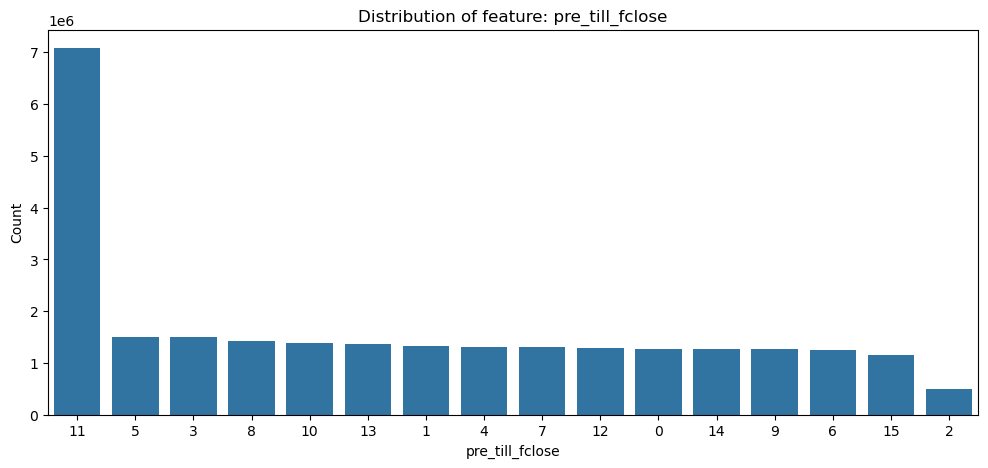

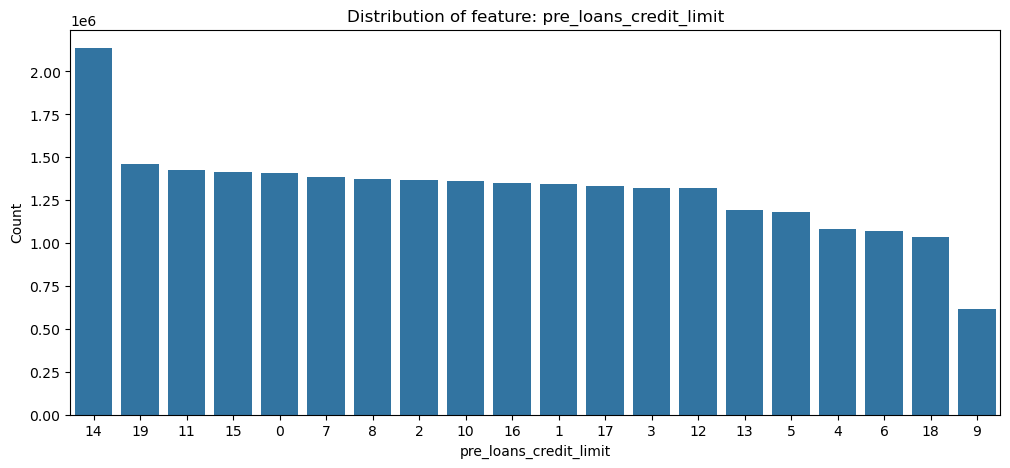

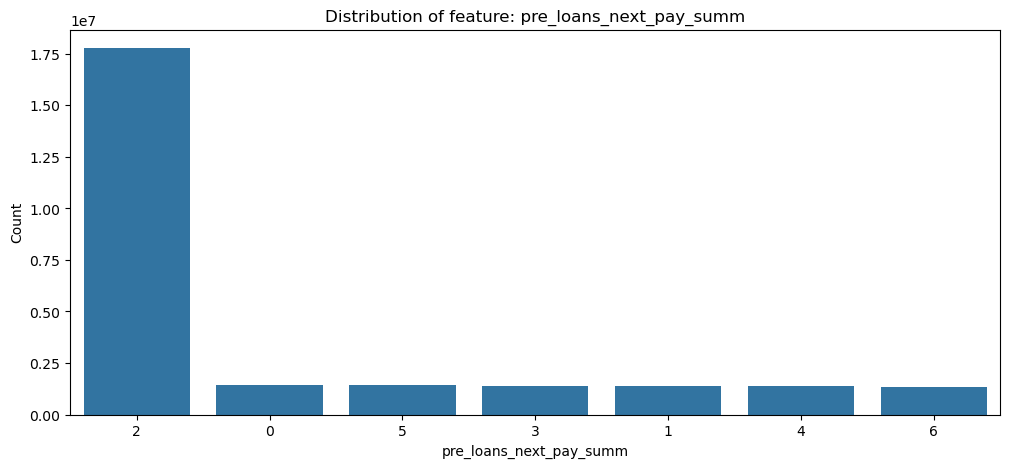

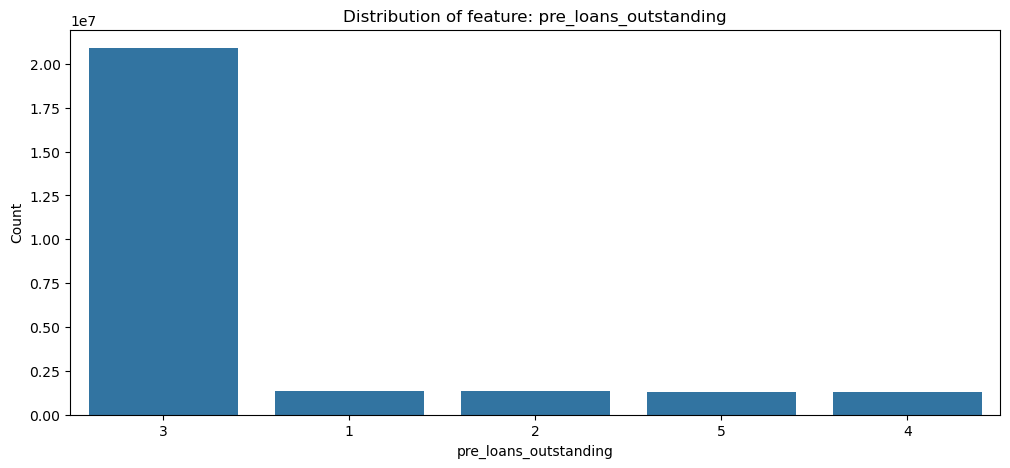

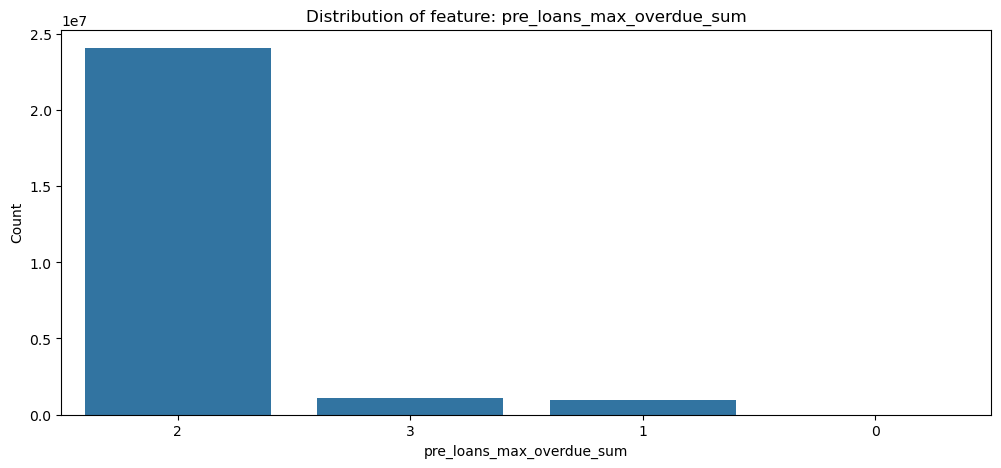

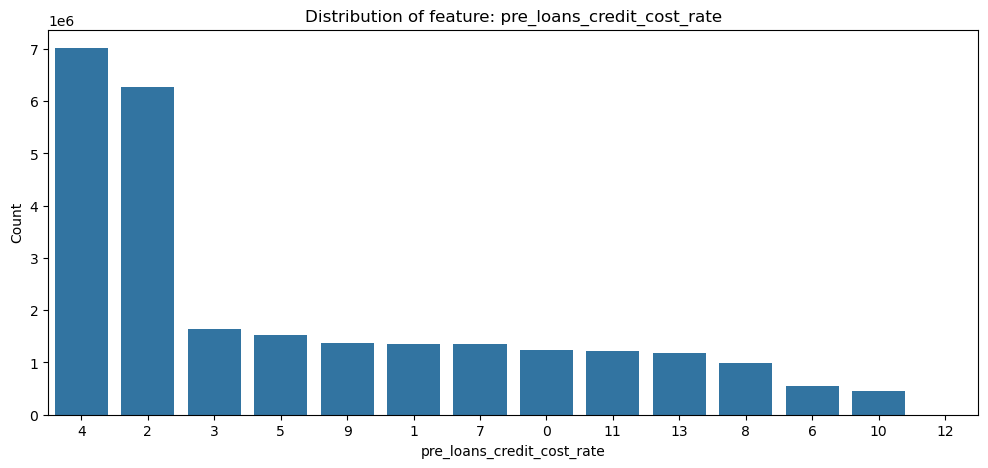

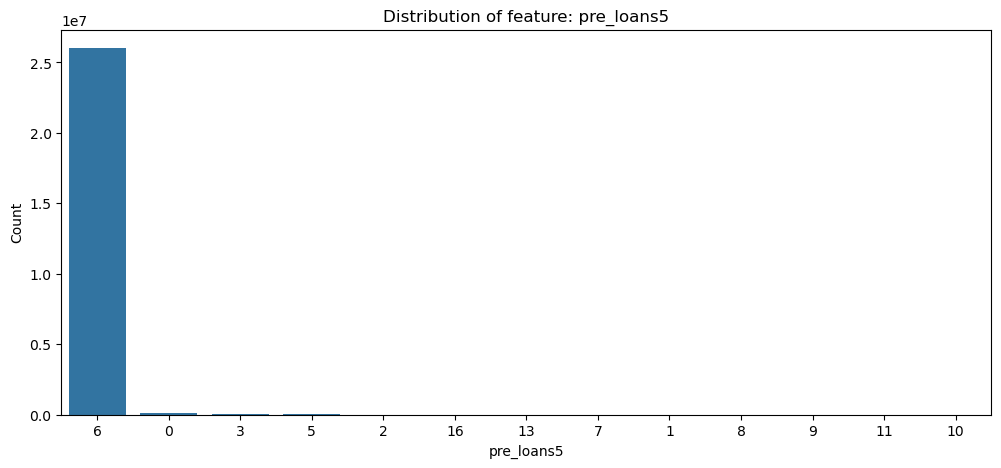

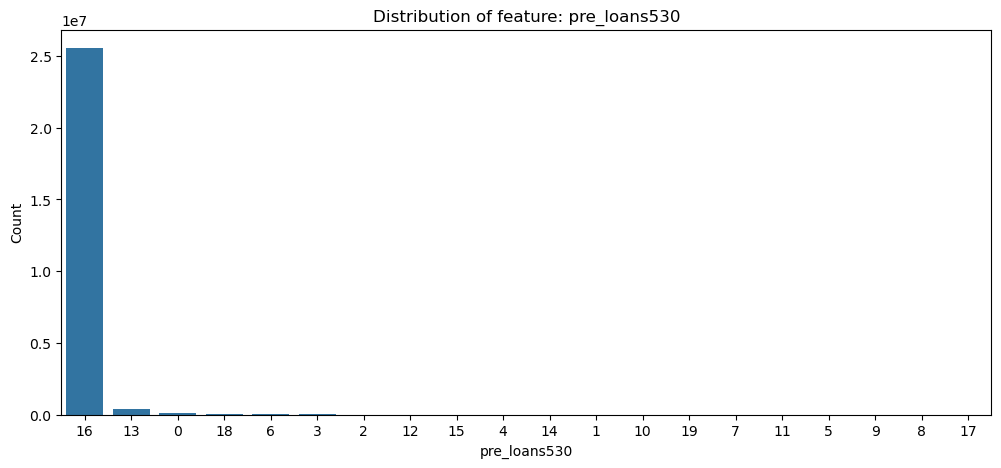

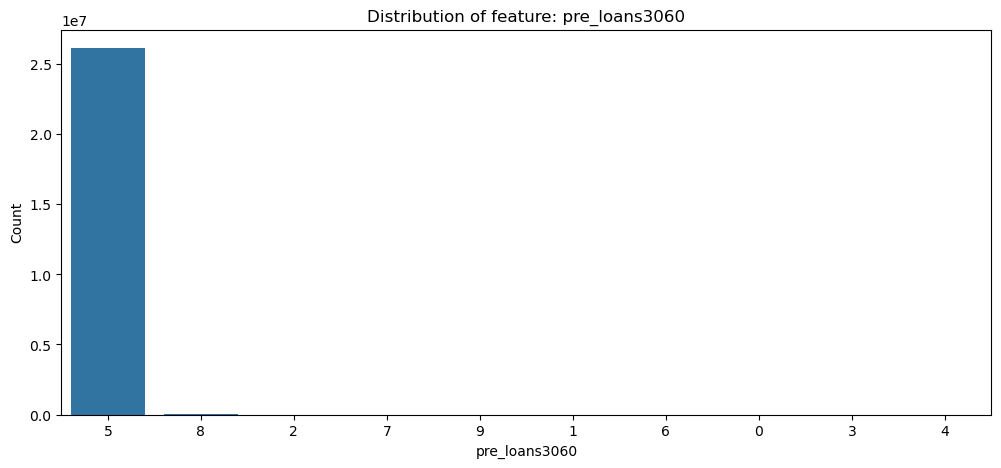

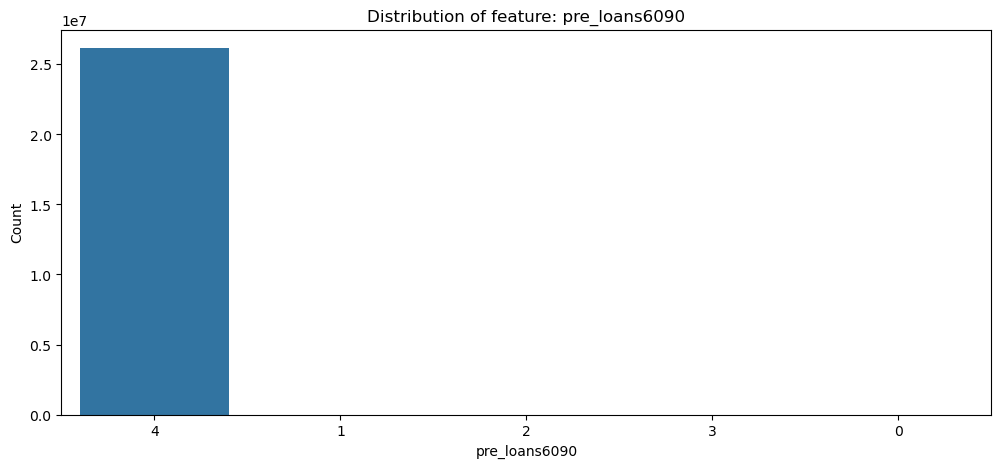

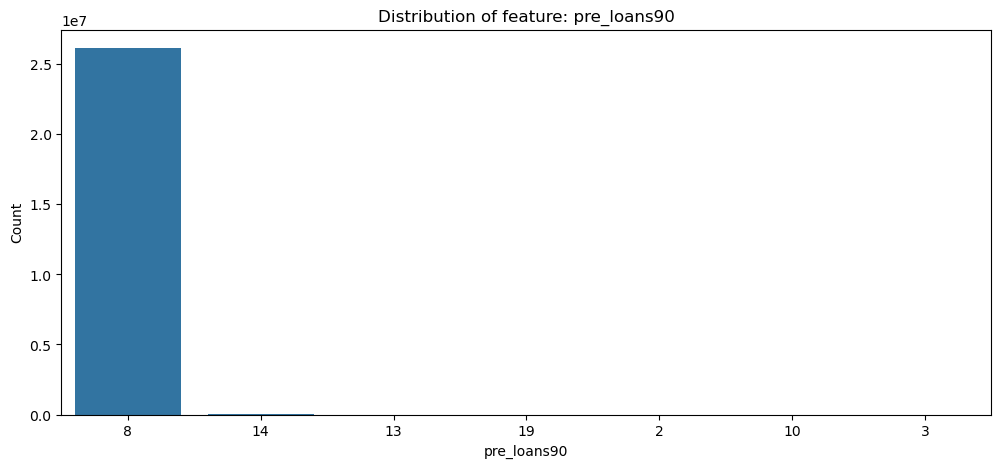

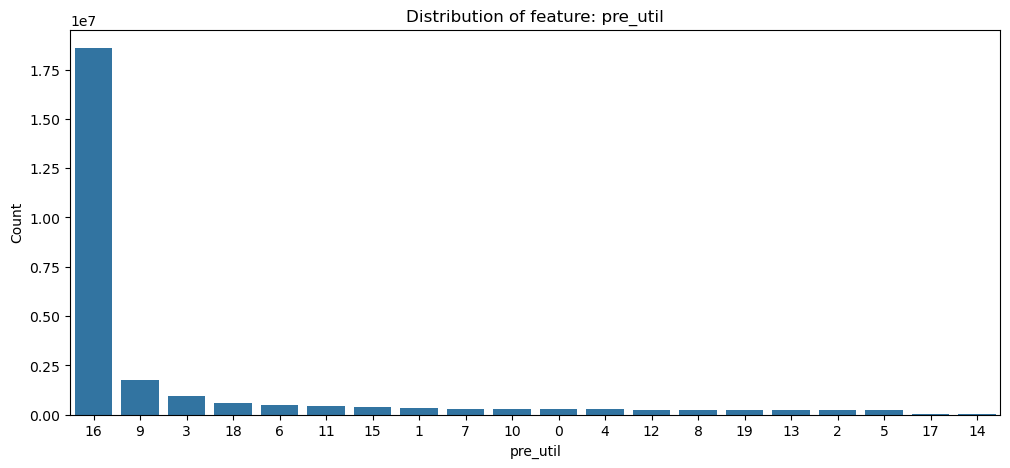

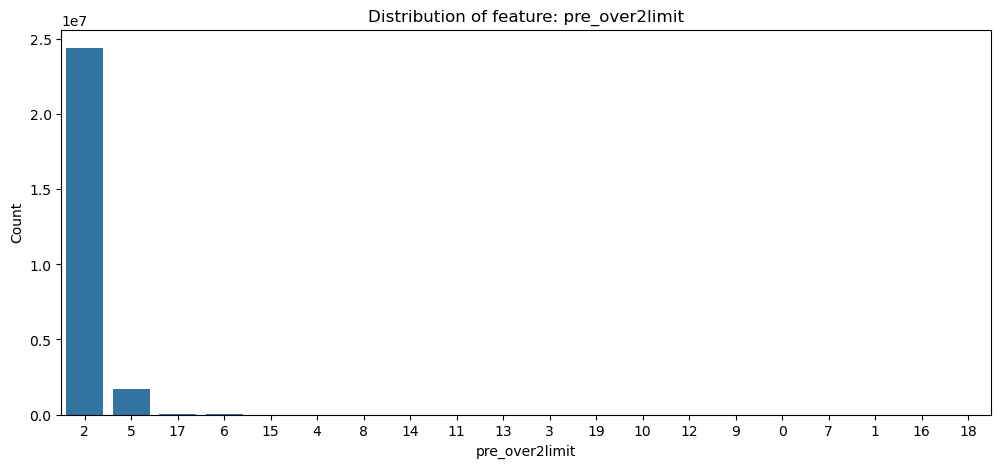

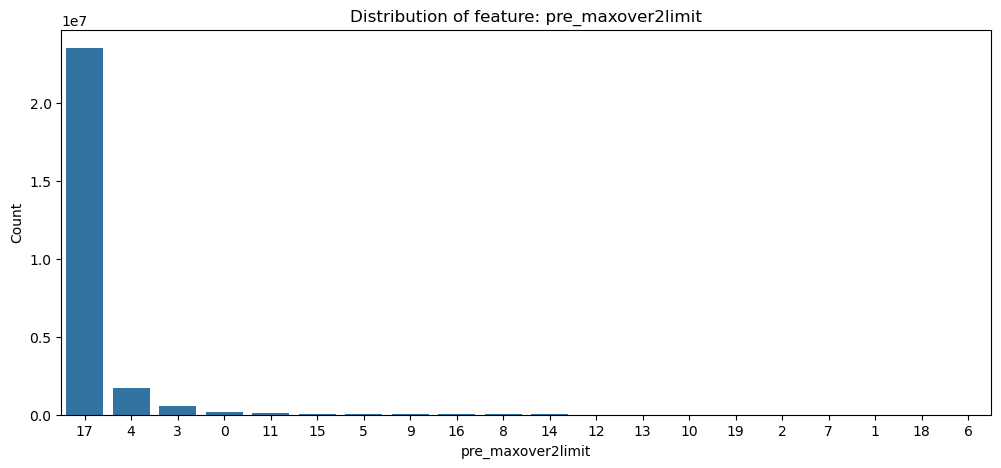

In [85]:
# Посмотрим на формы распределений признаков
for col in df[pre_features]:
    # Получаем частотности значений признака
    val_counts = df[col].value_counts()
    
    plt.figure(figsize=(12, 5))
    
    # Строим столбчатую диаграмму с порядком значений по убыванию частотности
    sns.barplot(
        x=val_counts.index,
        y=val_counts.values,
        order=val_counts.index
    )
    
    plt.title(f'Distribution of feature: {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

Распределения по большинству признаков сильно смещены: для многих из них наблюдается выраженное преобладание одного или нескольких значений, тогда как остальные встречаются значительно реже. Это говорит о наличии дисбаланса и специфических частотных свойств в данных, что, вероятно, соответствует дисбалансу таргета.

Бинаризация сильно искажает информацию о реальных значениях признаков: после неё нельзя утверждать, что большее значение бинаризованного признака соответствует большему количеству исходного или наоборот. При бинаризации теряется количественная информация, и признаки становятся лишь индикаторами попадания в некий общий интервал исходного признака.    
Поэтому для дальнейшей работы будем опираться на частотные свойства значений признаков.

### Create proportion value pre_features

In [60]:
df_train = pd.read_csv('prepared_data/rn_train.csv')
df_test = pd.read_csv('prepared_data/rn_test.csv')
df_train.shape, df_test.shape

((2400000, 3), (600000, 3))

In [35]:
''' 
Создадим словарь, где ключами будут имена исходных признаков из pre_features,
а значениями — три уникальных значения признака, на основе которых
были созданы новые частотные признаки с наибольшим вкладом в качество модели.
'''
pre_prop_features_dictionary = {}

for col in pre_features:
    print('-' * 50)
    print('Исходный признак:', col)
    
    # Создаём новые частотные признаки для каждого уникального значения признака col
    df_train, new_features_list = create_all_value_proportion_features(
        source_df_train,
        df_train,
        col
    )
    print('Новые признаки тренировочного датасета:\n' +
      '\n'.join(new_features_list))
    
    # Определяем 3 наиболее важных признака с помощью CatBoost
    values = choose_n_most_imp_features(df_train, new_features_list, 3)
    print('Наиболее важные категории признака:', values)
    
    # Сохраняем их в словарь
    pre_prop_features_dictionary[col] = values

    # Удаляем все новые признаки из тренировочного датафрейма
    df_train = df_train.drop(new_features_list, axis=1)

--------------------------------------------------
Исходный признак: pre_since_opened
Новые признаки тренировочного датасета:
pre_since_opened_prop_0
pre_since_opened_prop_1
pre_since_opened_prop_2
pre_since_opened_prop_3
pre_since_opened_prop_4
pre_since_opened_prop_5
pre_since_opened_prop_6
pre_since_opened_prop_7
pre_since_opened_prop_8
pre_since_opened_prop_9
pre_since_opened_prop_10
pre_since_opened_prop_11
pre_since_opened_prop_12
pre_since_opened_prop_13
pre_since_opened_prop_14
pre_since_opened_prop_15
pre_since_opened_prop_16
pre_since_opened_prop_17
pre_since_opened_prop_18
pre_since_opened_prop_19
Среднее ROC AUC на трейне: 0.6363
Стандартное отклонение ROC AUC на трейне: 0.0018
Среднее ROC AUC на валидации: 0.6219
Стандартное отклонение ROC AUC на валидации: 0.0012
Наиболее важные категории признака: [12, 19, 8]
--------------------------------------------------
Исходный признак: pre_since_confirmed
Новые признаки тренировочного датасета:
pre_since_confirmed_prop_0
pre_sinc

{'pre_since_opened': [12, 19, 8],
 'pre_since_confirmed': [7, 4, 9],
 'pre_pterm': [6, 3, 4],
 'pre_fterm': [3, 8, 7],
 'pre_till_pclose': [0, 10, 7],
 'pre_till_fclose': [4, 3, 1],
 'pre_loans_credit_limit': [2, 18, 15],
 'pre_loans_next_pay_summ': [5, 2, 0],
 'pre_loans_outstanding': [3, 5, 1],
 'pre_loans_max_overdue_sum': [2, 1, 3],
 'pre_loans_credit_cost_rate': [6, 4, 11],
 'pre_loans5': [6, 0, 3],
 'pre_loans530': [13, 16, 2],
 'pre_loans3060': [5, 8, 9],
 'pre_loans6090': [4, 2, 1],
 'pre_loans90': [8, 14, 13],
 'pre_util': [16, 6, 3],
 'pre_over2limit': [2, 5, 17],
 'pre_maxover2limit': [17, 4, 9]}

In [36]:
pre_prop_features_dictionary

{'pre_since_opened': [12, 19, 8],
 'pre_since_confirmed': [7, 4, 9],
 'pre_pterm': [6, 3, 4],
 'pre_fterm': [3, 8, 7],
 'pre_till_pclose': [0, 10, 7],
 'pre_till_fclose': [4, 3, 1],
 'pre_loans_credit_limit': [2, 18, 15],
 'pre_loans_next_pay_summ': [5, 2, 0],
 'pre_loans_outstanding': [3, 5, 1],
 'pre_loans_max_overdue_sum': [2, 1, 3],
 'pre_loans_credit_cost_rate': [6, 4, 11],
 'pre_loans5': [6, 0, 3],
 'pre_loans530': [13, 16, 2],
 'pre_loans3060': [5, 8, 9],
 'pre_loans6090': [4, 2, 1],
 'pre_loans90': [8, 14, 13],
 'pre_util': [16, 6, 3],
 'pre_over2limit': [2, 5, 17],
 'pre_maxover2limit': [17, 4, 9]}

In [41]:
# Создадим выбранные признаки в тренировочном датасете
df_train = create_definite_value_proportion_features(
    source_df_train,
    df_train,
    pre_prop_features_dictionary
)

Исходный признак: pre_since_opened
Новые фичи:
pre_since_opened_prop_12
pre_since_opened_prop_19
pre_since_opened_prop_8
Исходный признак: pre_since_confirmed
Новые фичи:
pre_since_confirmed_prop_7
pre_since_confirmed_prop_4
pre_since_confirmed_prop_9
Исходный признак: pre_pterm
Новые фичи:
pre_pterm_prop_6
pre_pterm_prop_3
pre_pterm_prop_4
Исходный признак: pre_fterm
Новые фичи:
pre_fterm_prop_3
pre_fterm_prop_8
pre_fterm_prop_7
Исходный признак: pre_till_pclose
Новые фичи:
pre_till_pclose_prop_0
pre_till_pclose_prop_10
pre_till_pclose_prop_7
Исходный признак: pre_till_fclose
Новые фичи:
pre_till_fclose_prop_4
pre_till_fclose_prop_3
pre_till_fclose_prop_1
Исходный признак: pre_loans_credit_limit
Новые фичи:
pre_loans_credit_limit_prop_2
pre_loans_credit_limit_prop_18
pre_loans_credit_limit_prop_15
Исходный признак: pre_loans_next_pay_summ
Новые фичи:
pre_loans_next_pay_summ_prop_5
pre_loans_next_pay_summ_prop_2
pre_loans_next_pay_summ_prop_0
Исходный признак: pre_loans_outstanding
Нов

In [42]:
# Создадим выбранные признаки в тестовом датасете
df_test = create_definite_value_proportion_features(
    source_df_test,
    df_test,
    pre_prop_features_dictionary
)

Исходный признак: pre_since_opened
Новые фичи:
pre_since_opened_prop_12
pre_since_opened_prop_19
pre_since_opened_prop_8
Исходный признак: pre_since_confirmed
Новые фичи:
pre_since_confirmed_prop_7
pre_since_confirmed_prop_4
pre_since_confirmed_prop_9
Исходный признак: pre_pterm
Новые фичи:
pre_pterm_prop_6
pre_pterm_prop_3
pre_pterm_prop_4
Исходный признак: pre_fterm
Новые фичи:
pre_fterm_prop_3
pre_fterm_prop_8
pre_fterm_prop_7
Исходный признак: pre_till_pclose
Новые фичи:
pre_till_pclose_prop_0
pre_till_pclose_prop_10
pre_till_pclose_prop_7
Исходный признак: pre_till_fclose
Новые фичи:
pre_till_fclose_prop_4
pre_till_fclose_prop_3
pre_till_fclose_prop_1
Исходный признак: pre_loans_credit_limit
Новые фичи:
pre_loans_credit_limit_prop_2
pre_loans_credit_limit_prop_18
pre_loans_credit_limit_prop_15
Исходный признак: pre_loans_next_pay_summ
Новые фичи:
pre_loans_next_pay_summ_prop_5
pre_loans_next_pay_summ_prop_2
pre_loans_next_pay_summ_prop_0
Исходный признак: pre_loans_outstanding
Нов

In [43]:
# Запишем промежуточные результаты в файлы
df_train.to_csv('prepared_data/pre_prop_rn_train.csv', index=False)
df_test.to_csv('prepared_data/pre_prop_rn_test.csv', index=False)
df_train.shape, df_test.shape

((2400000, 60), (600000, 60))

In [45]:
# Посмотрим на количество уникальных значений в новых фичах
columns = df_train.columns[3:]

for col in columns:
    print(df_train[col].nunique(), col)

483 pre_since_opened_prop_12
370 pre_since_opened_prop_19
255 pre_since_opened_prop_8
226 pre_since_confirmed_prop_7
240 pre_since_confirmed_prop_4
463 pre_since_confirmed_prop_9
230 pre_pterm_prop_6
493 pre_pterm_prop_3
536 pre_pterm_prop_4
483 pre_fterm_prop_3
495 pre_fterm_prop_8
199 pre_fterm_prop_7
222 pre_till_pclose_prop_0
273 pre_till_pclose_prop_10
452 pre_till_pclose_prop_7
182 pre_till_fclose_prop_4
245 pre_till_fclose_prop_3
236 pre_till_fclose_prop_1
320 pre_loans_credit_limit_prop_2
453 pre_loans_credit_limit_prop_18
228 pre_loans_credit_limit_prop_15
300 pre_loans_next_pay_summ_prop_5
468 pre_loans_next_pay_summ_prop_2
229 pre_loans_next_pay_summ_prop_0
336 pre_loans_outstanding_prop_3
152 pre_loans_outstanding_prop_5
205 pre_loans_outstanding_prop_1
335 pre_loans_max_overdue_sum_prop_2
289 pre_loans_max_overdue_sum_prop_1
238 pre_loans_max_overdue_sum_prop_3
521 pre_loans_credit_cost_rate_prop_6
512 pre_loans_credit_cost_rate_prop_4
287 pre_loans_credit_cost_rate_prop_1

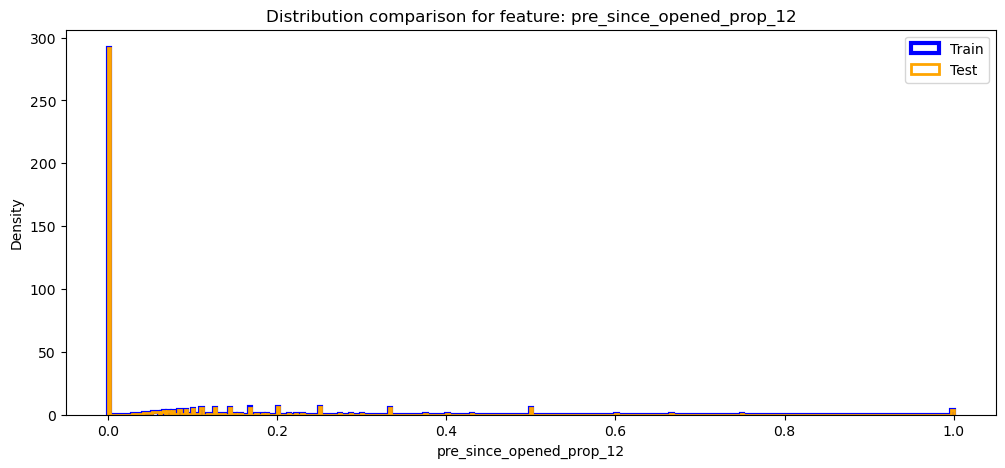

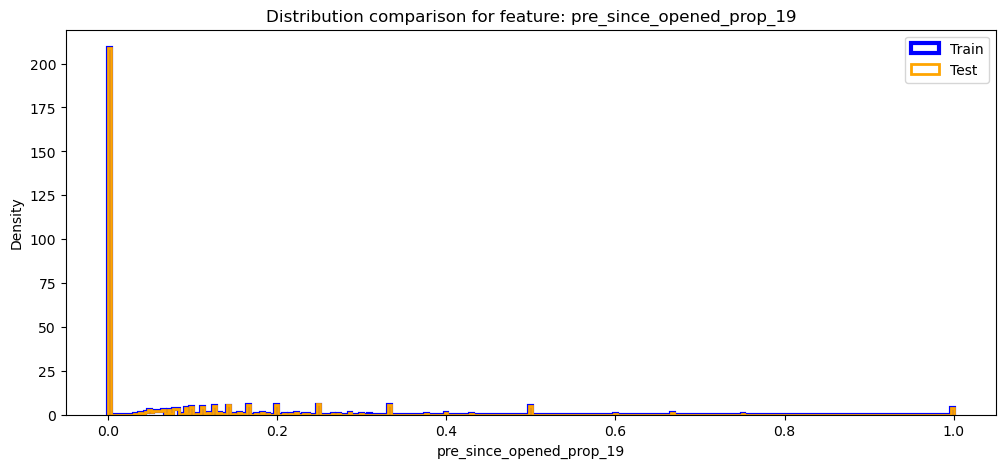

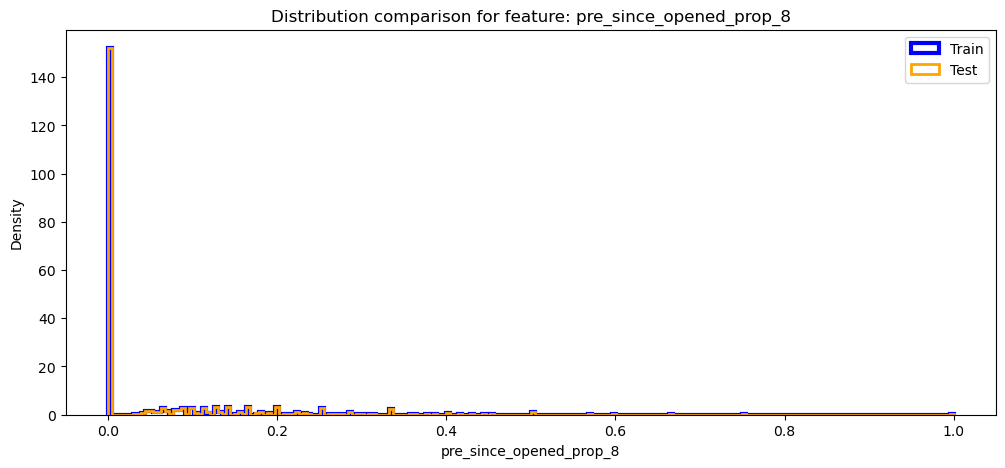

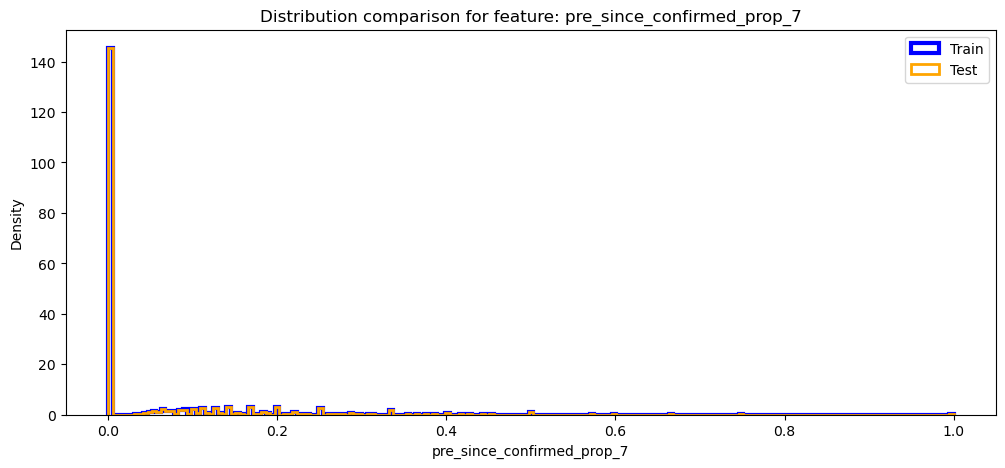

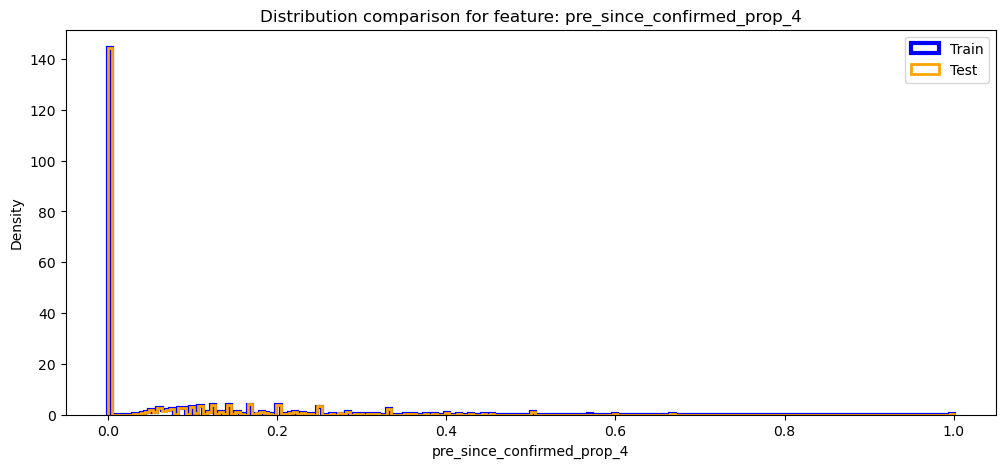

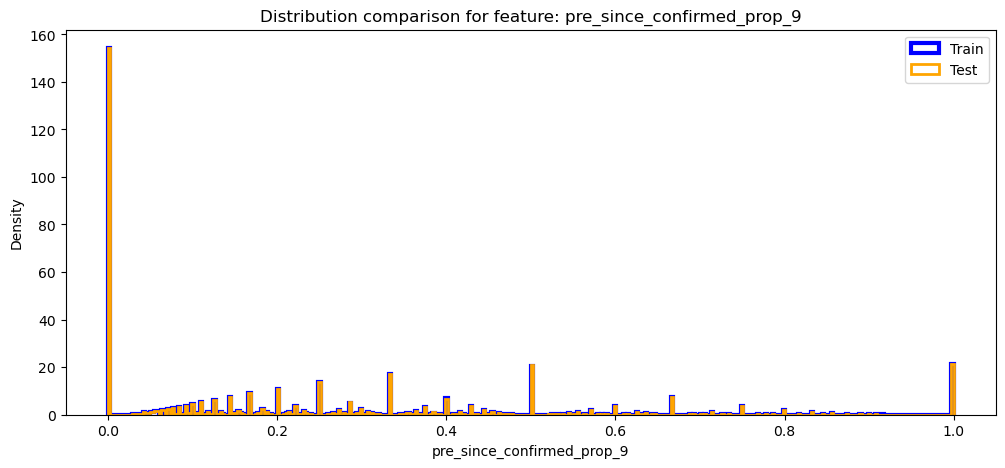

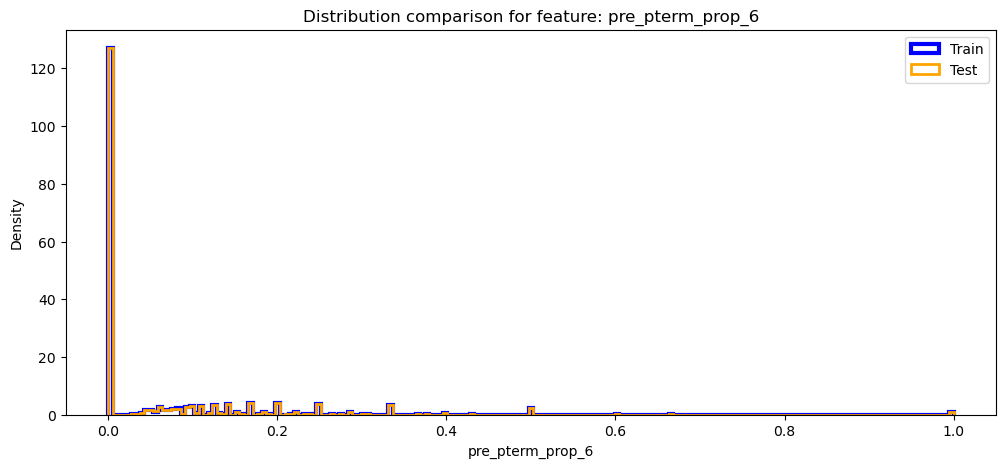

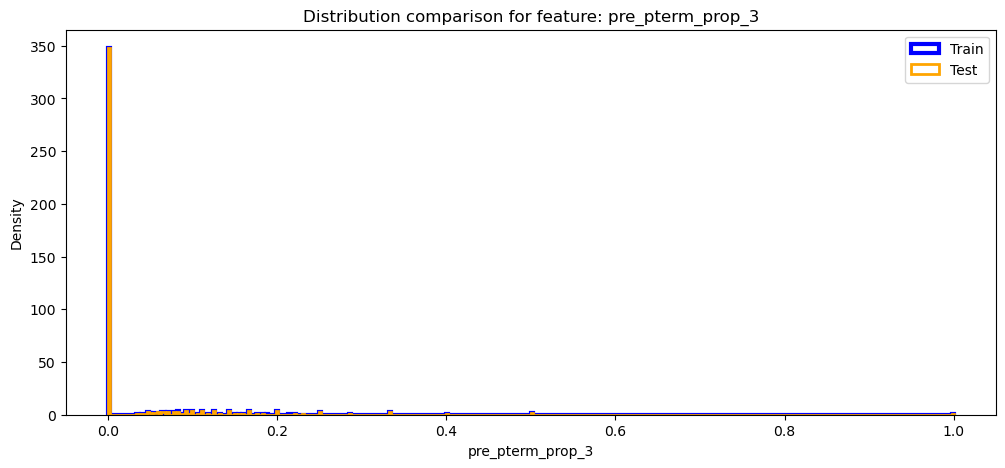

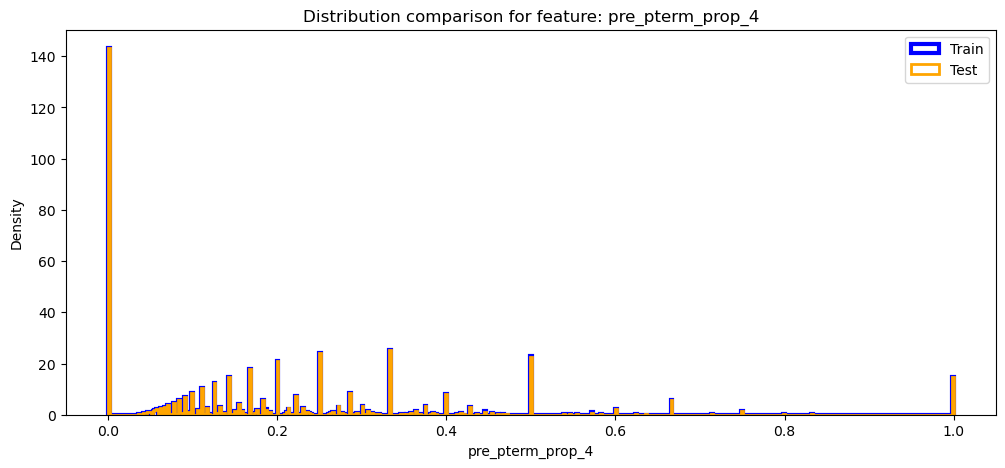

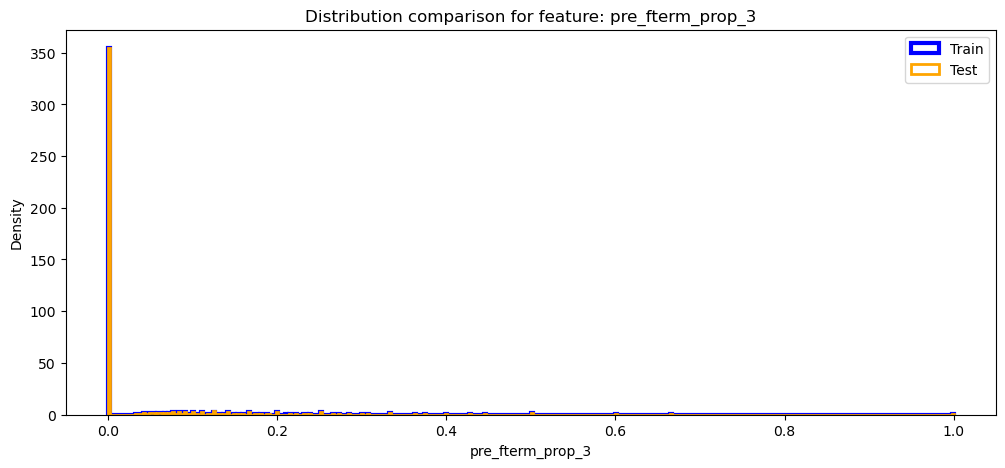

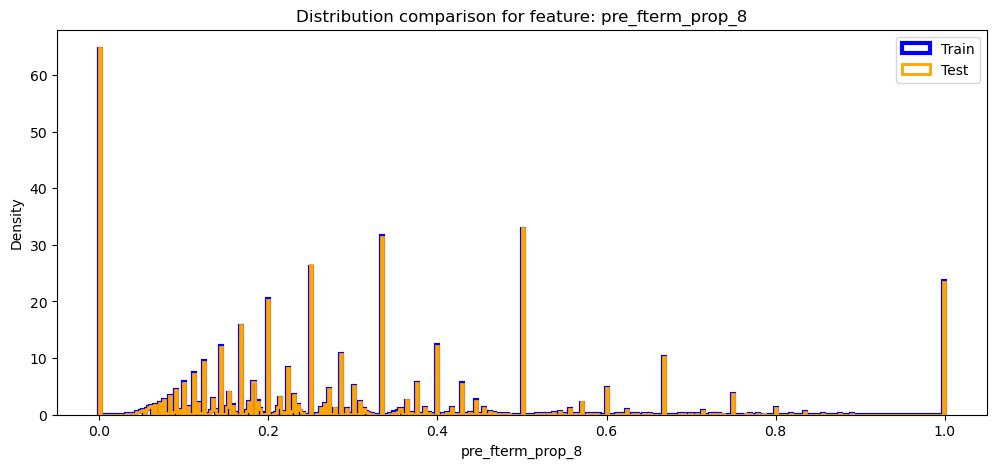

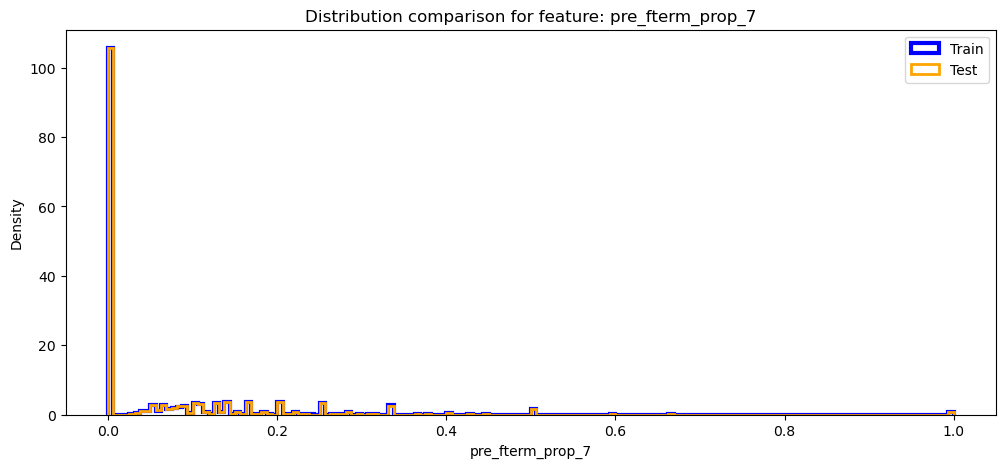

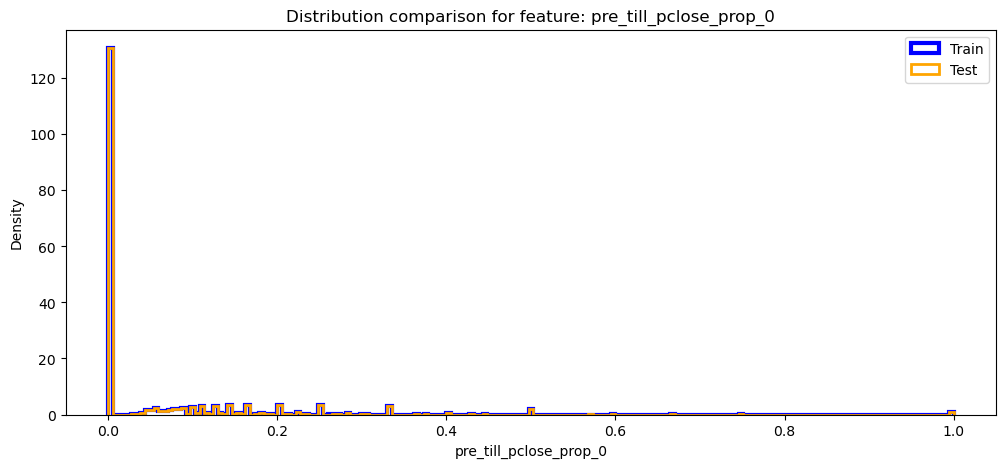

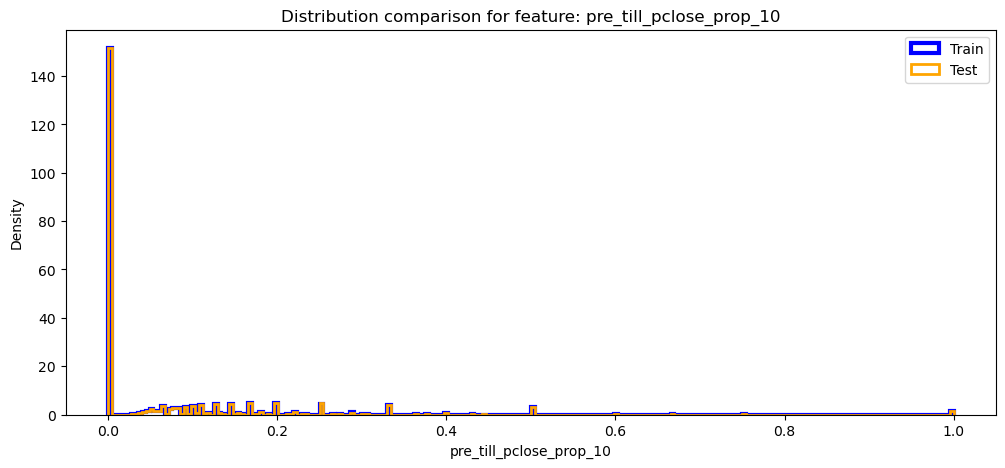

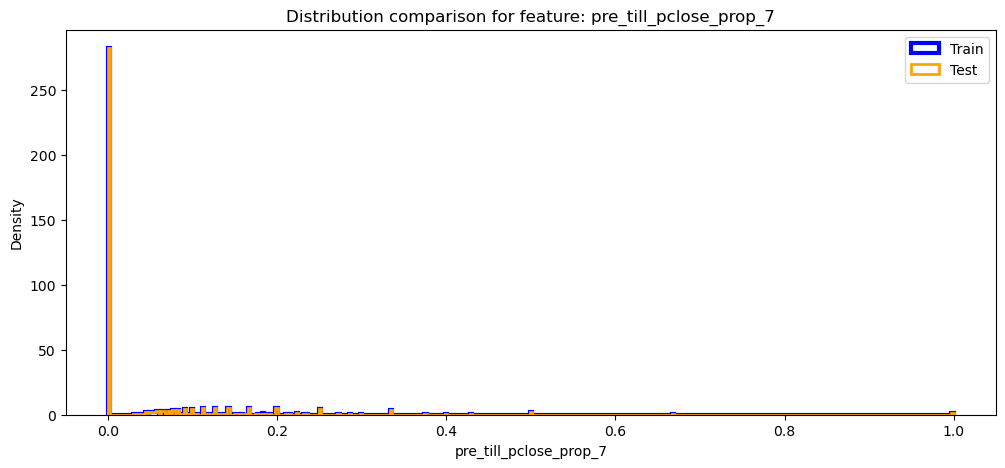

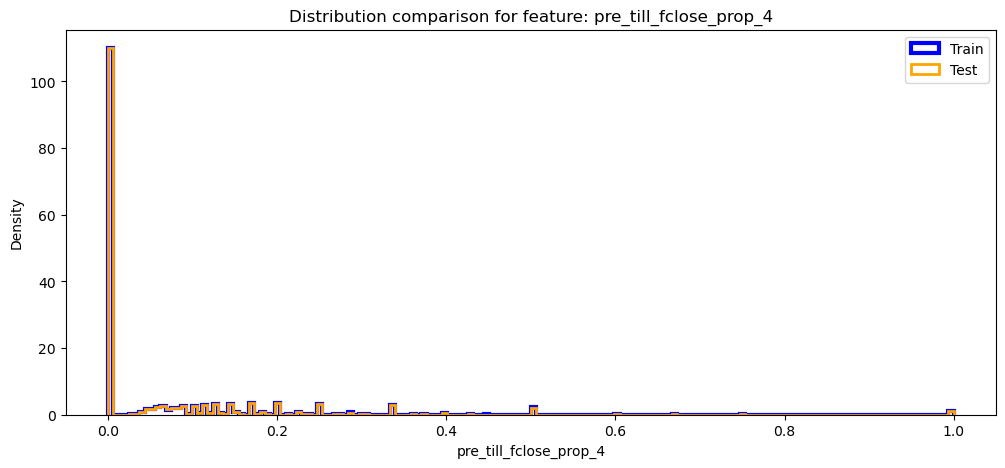

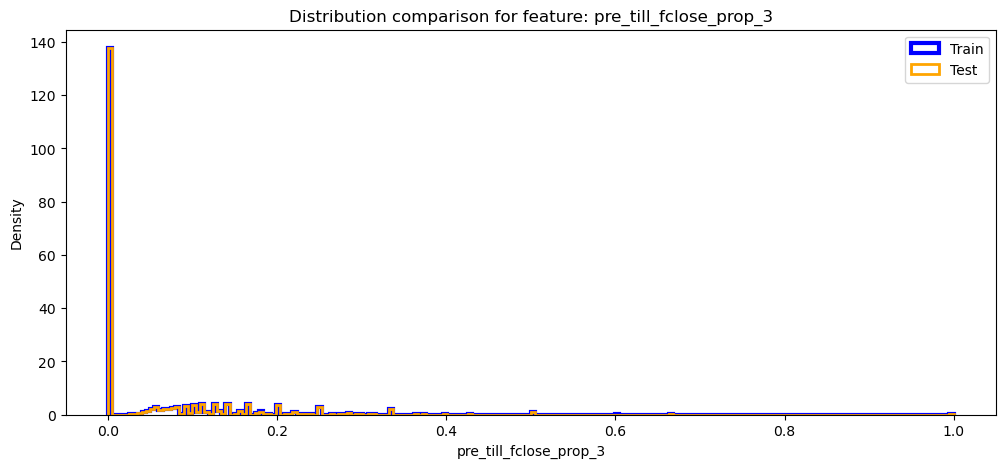

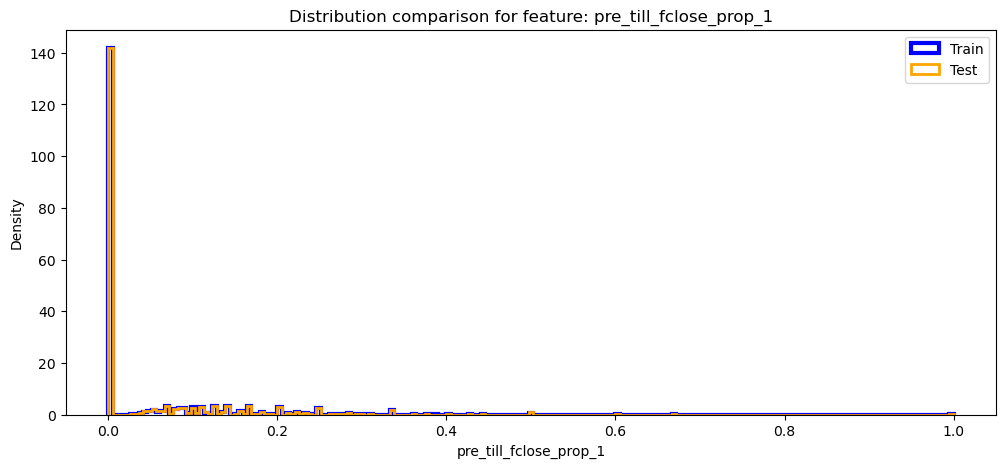

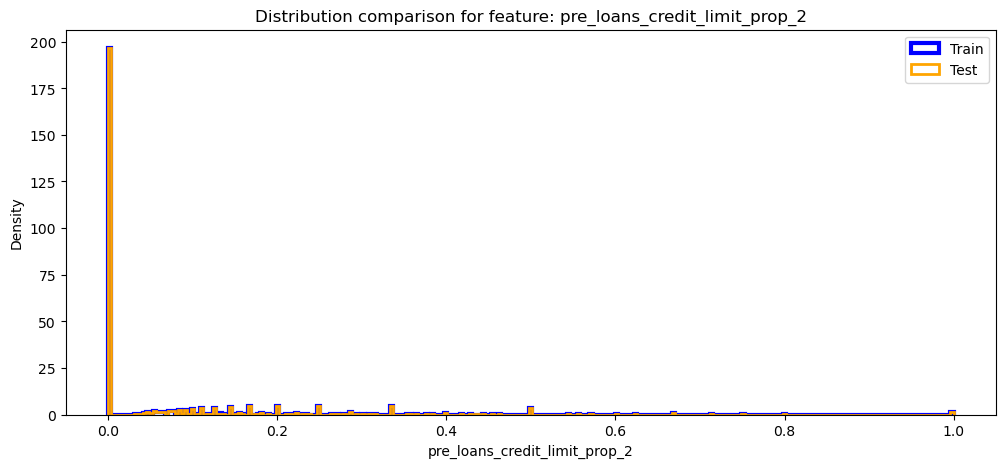

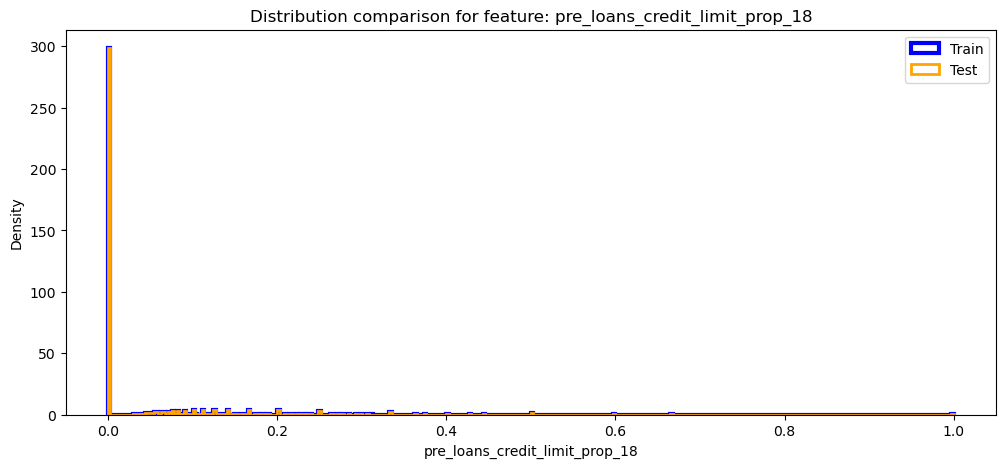

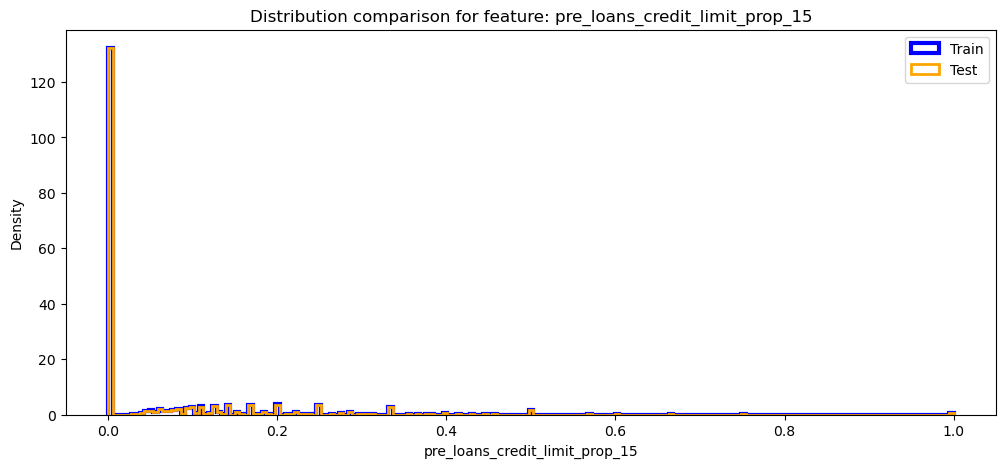

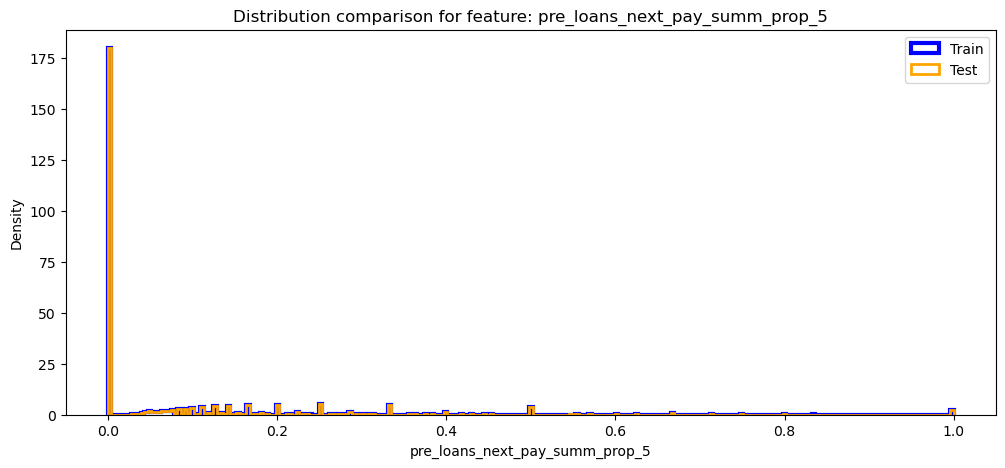

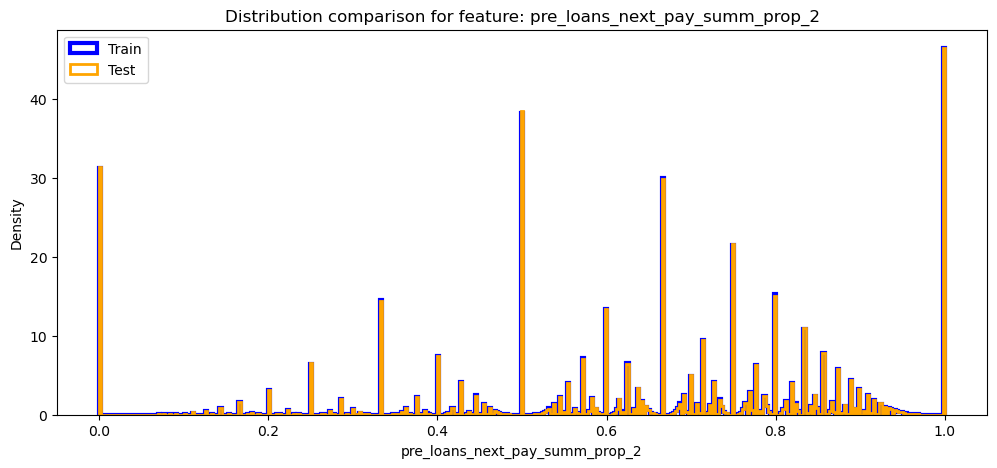

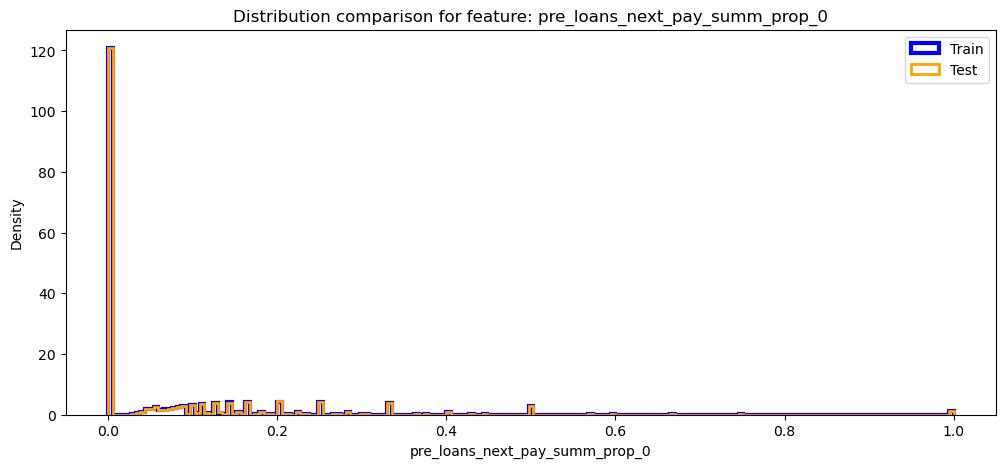

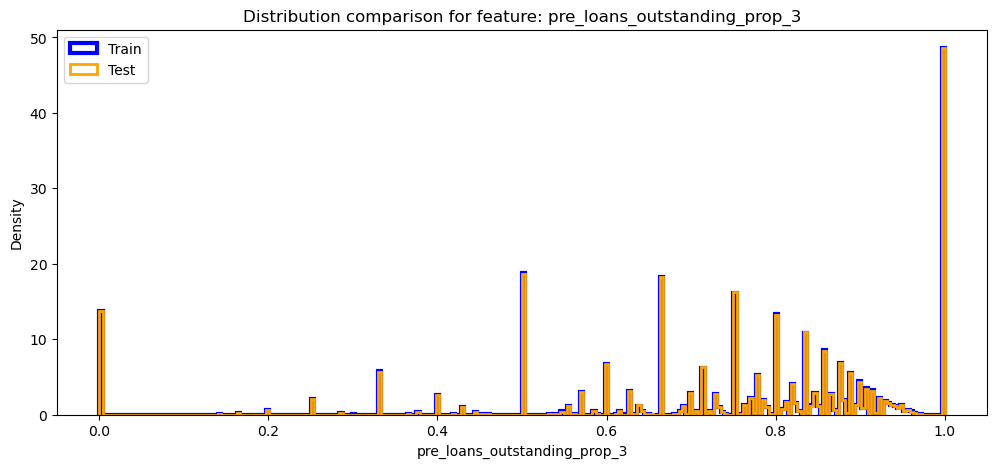

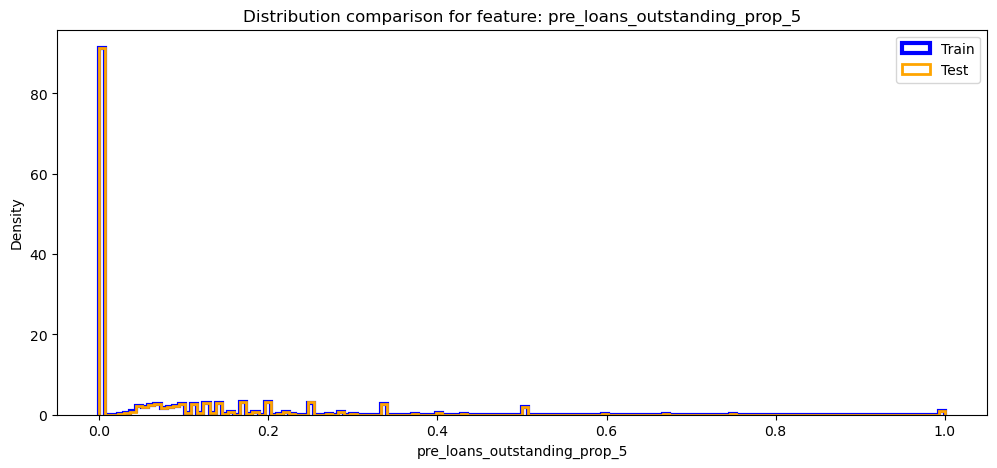

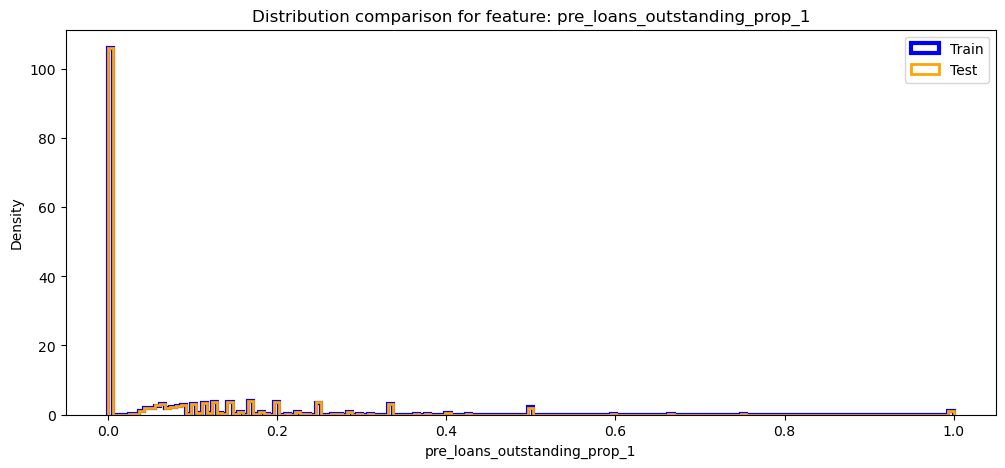

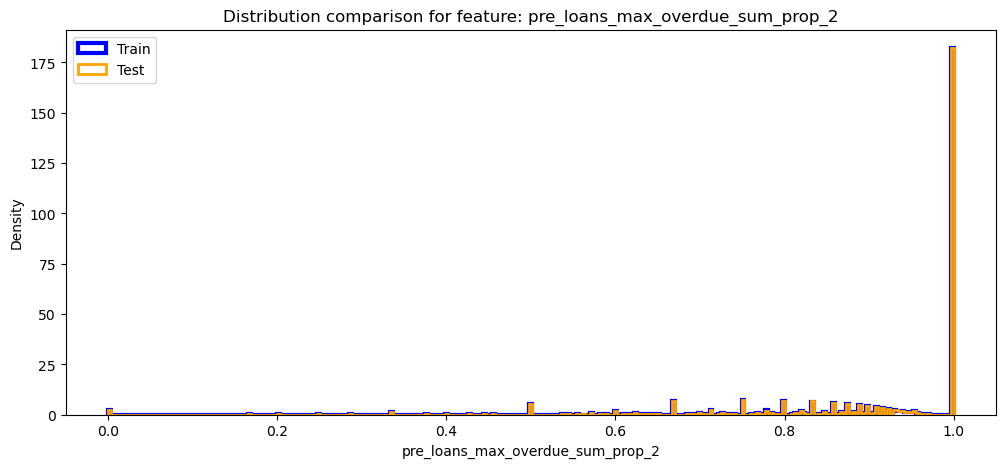

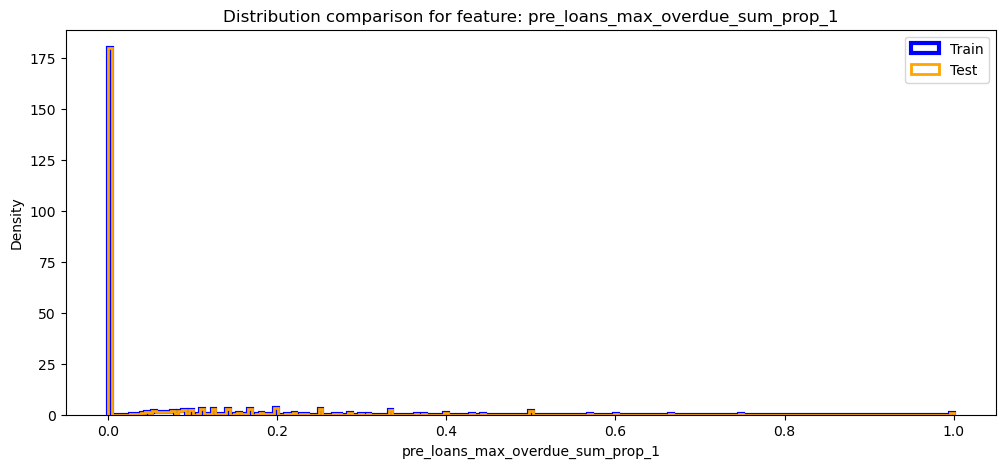

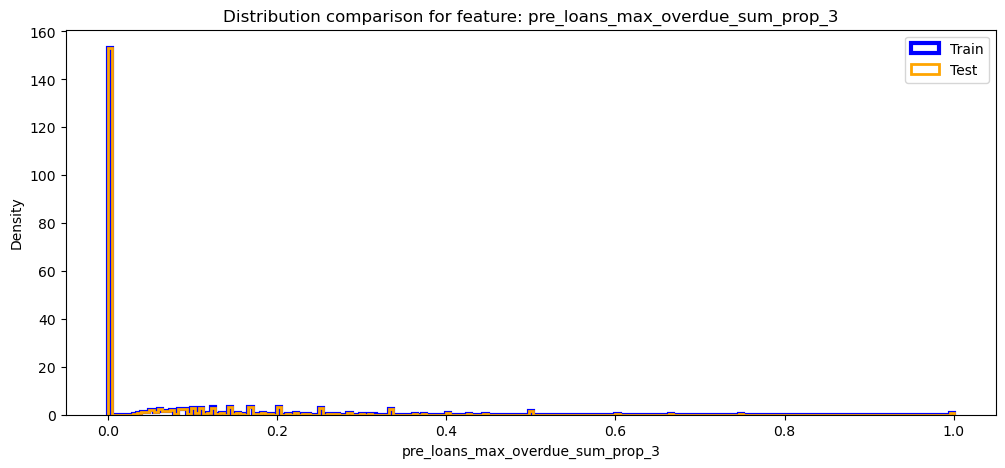

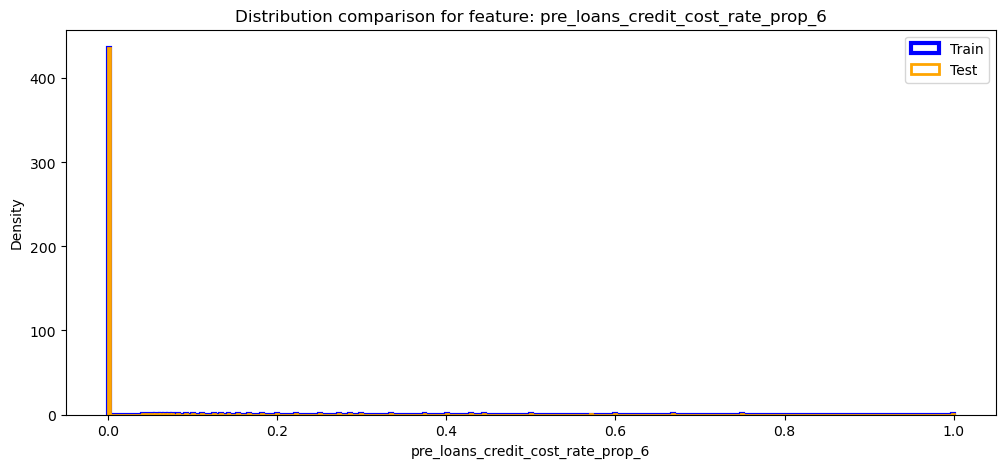

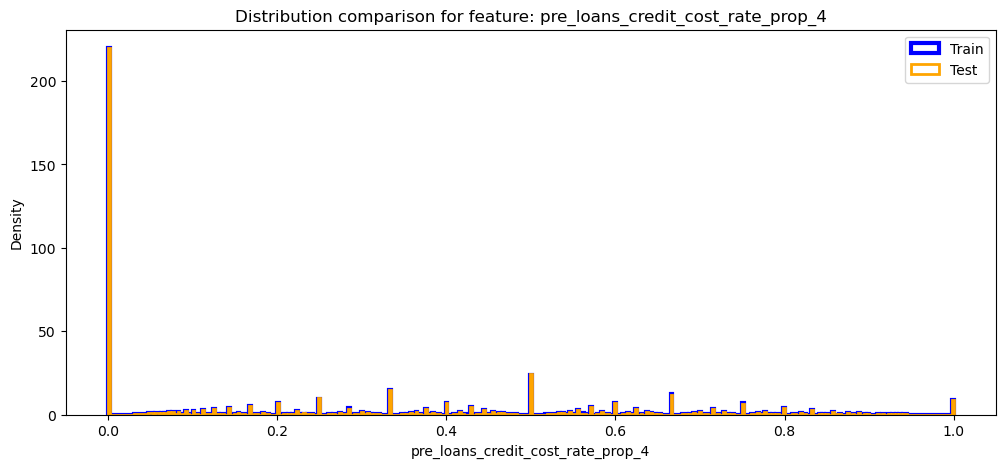

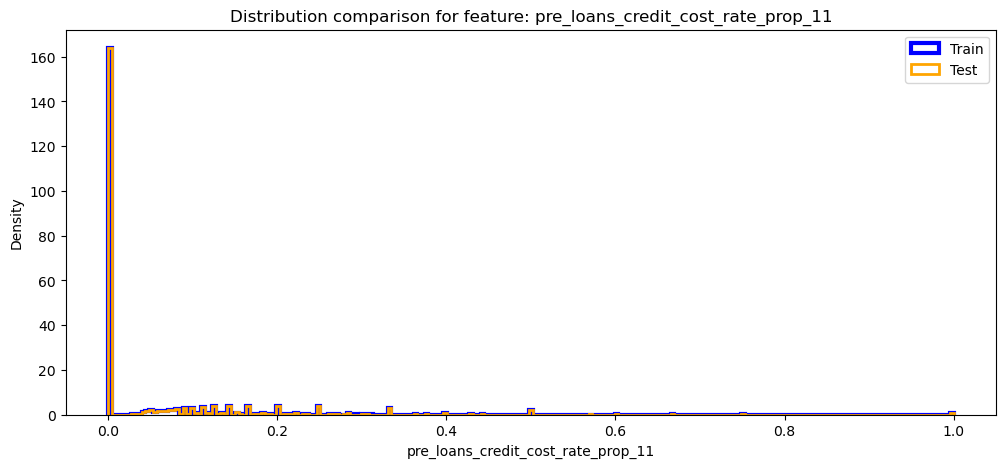

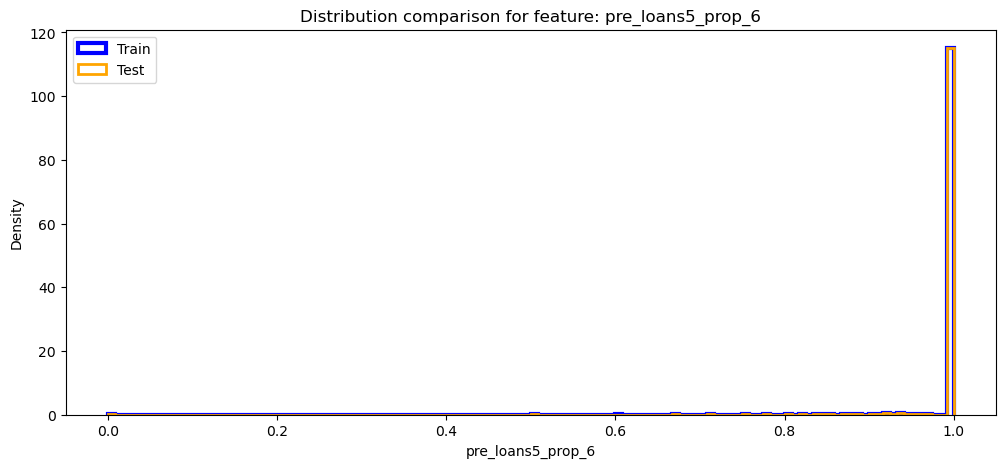

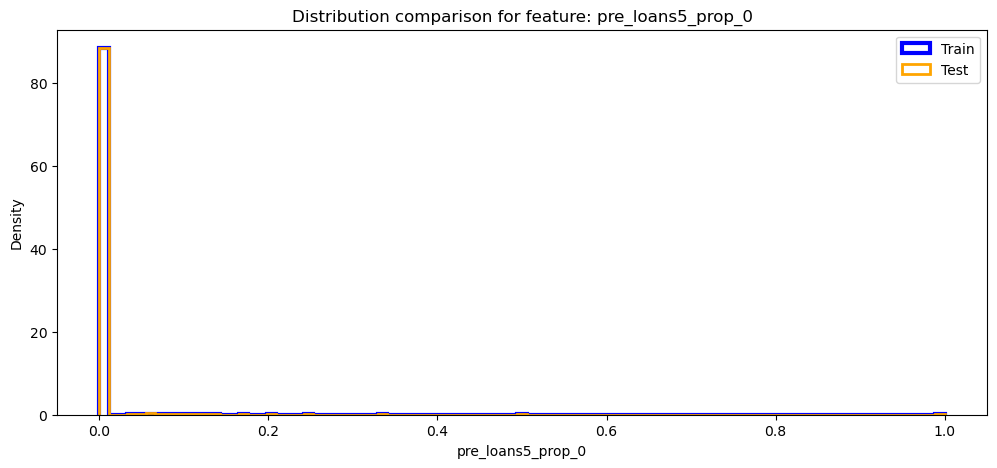

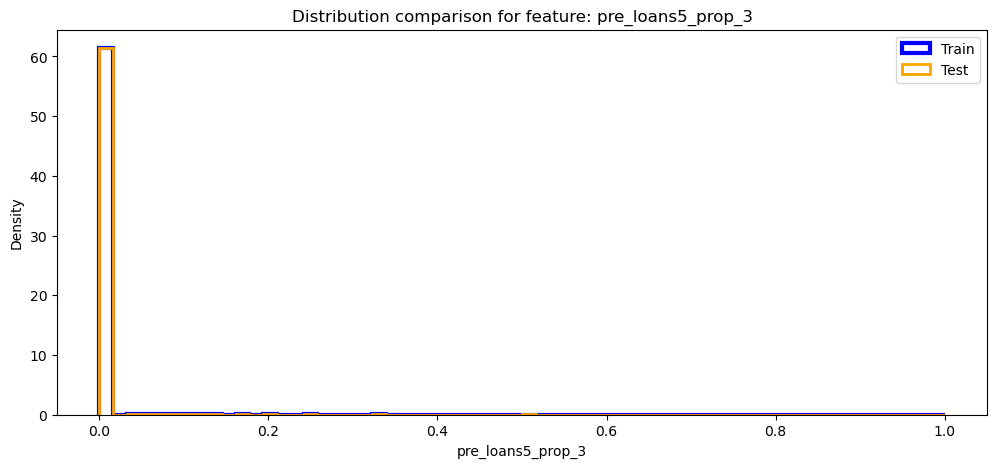

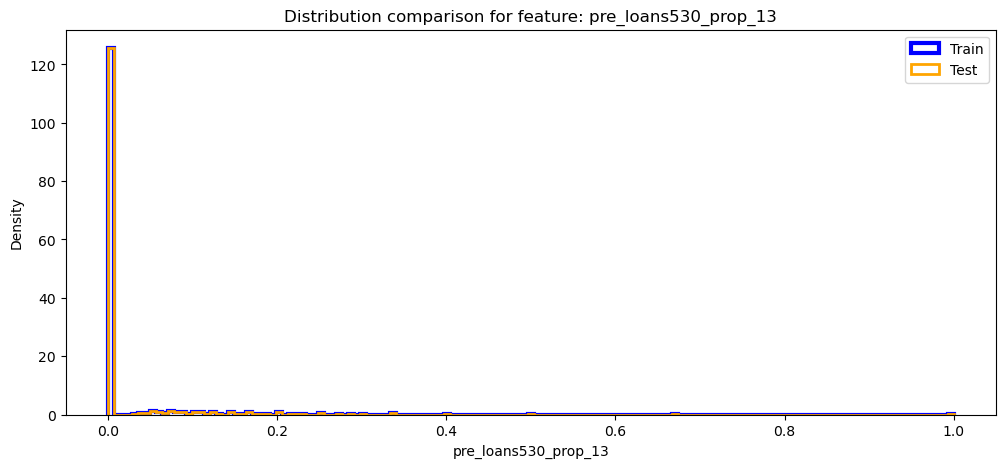

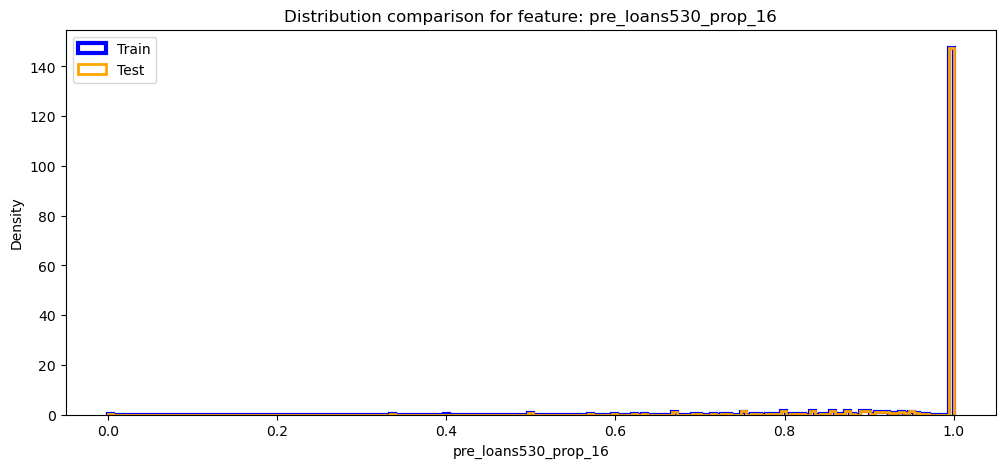

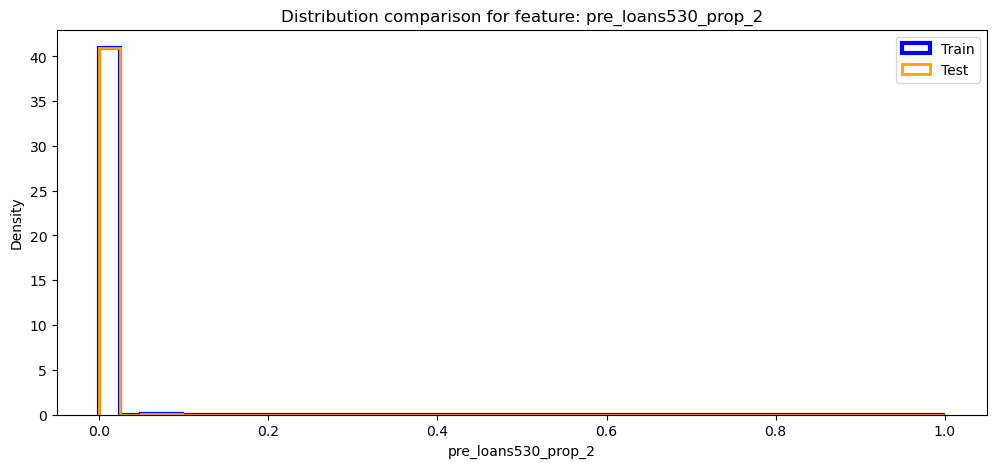

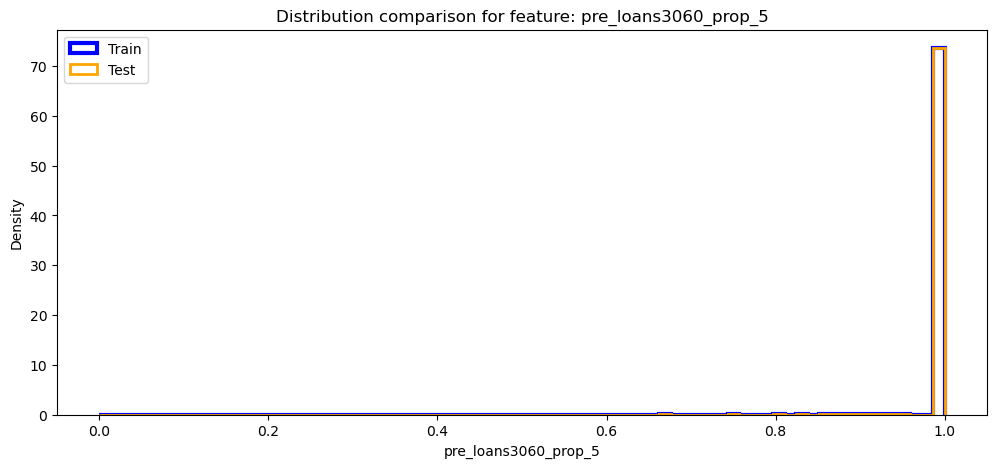

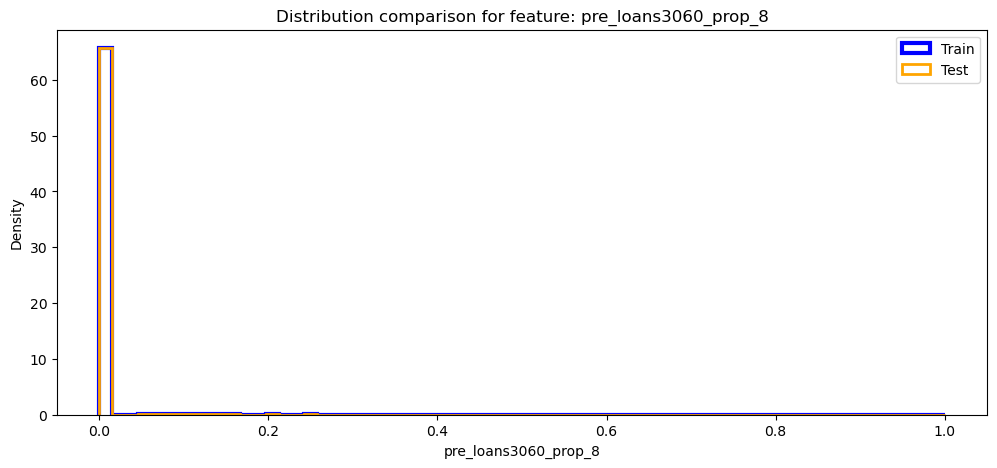

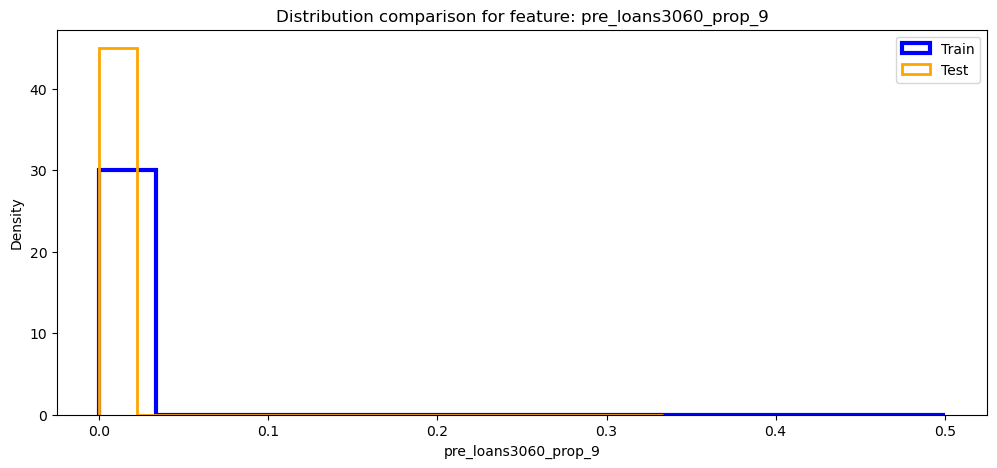

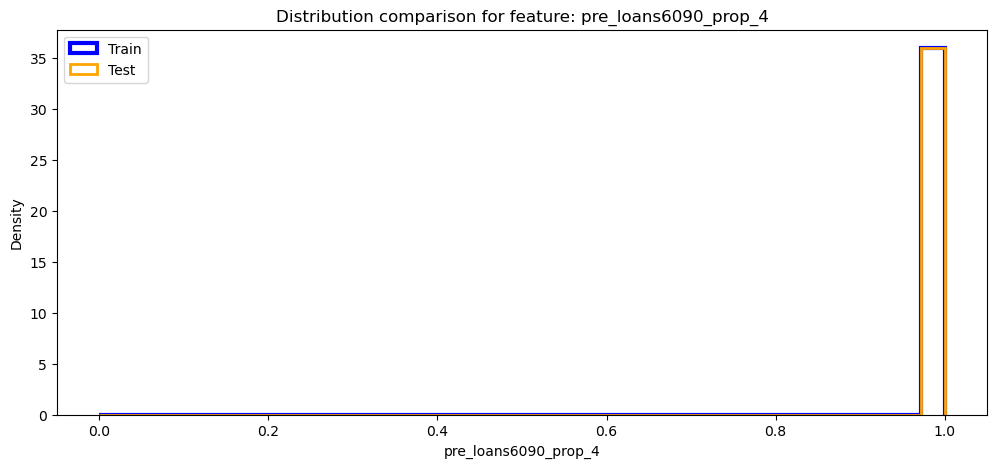

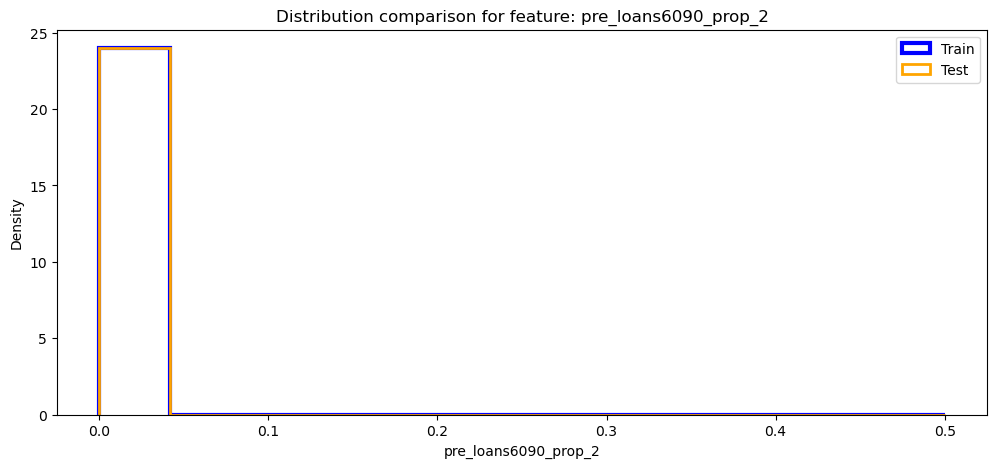

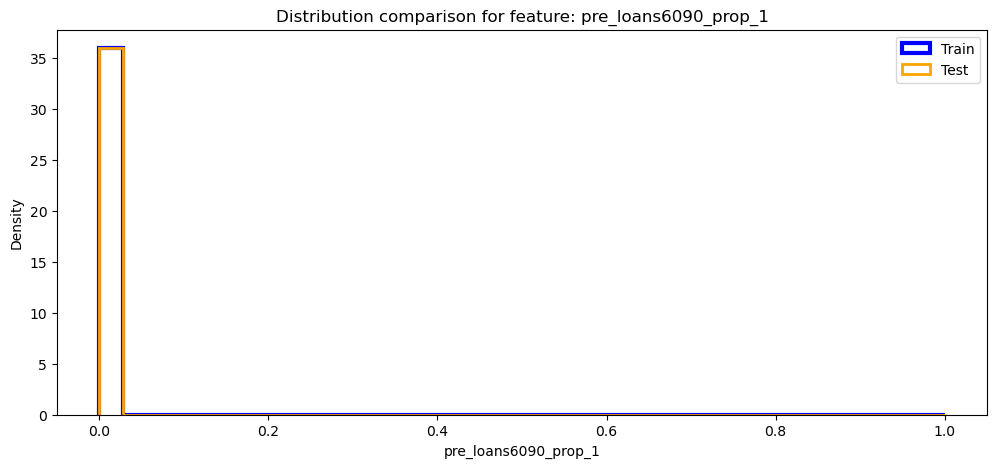

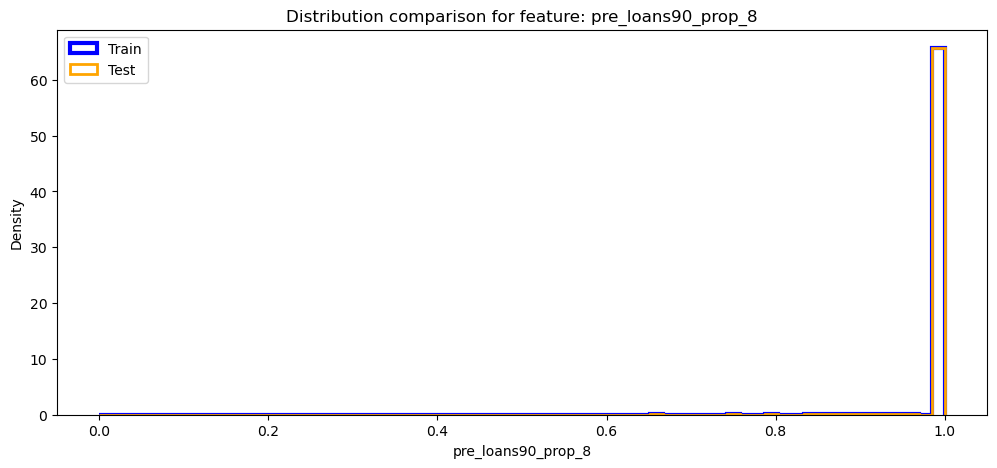

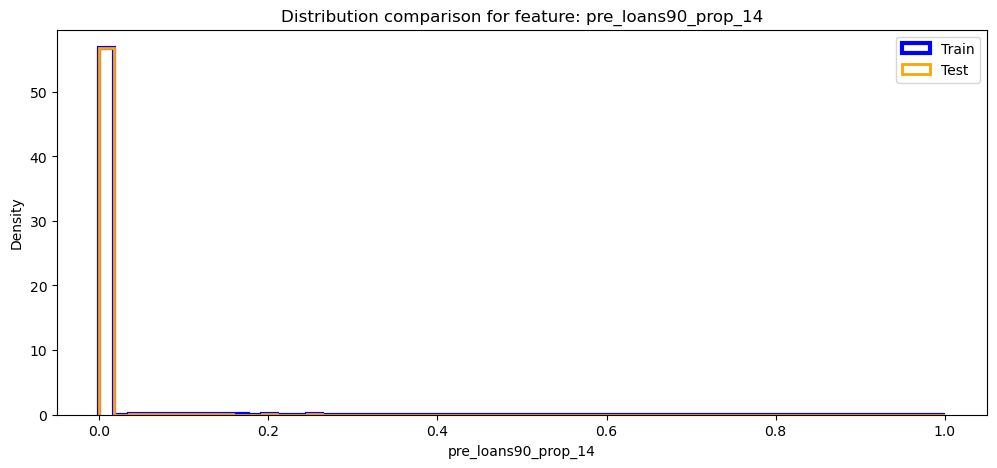

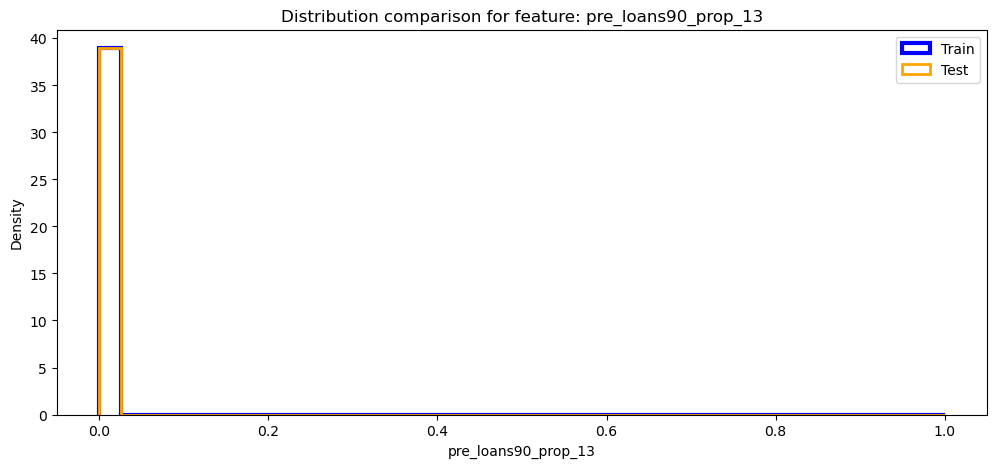

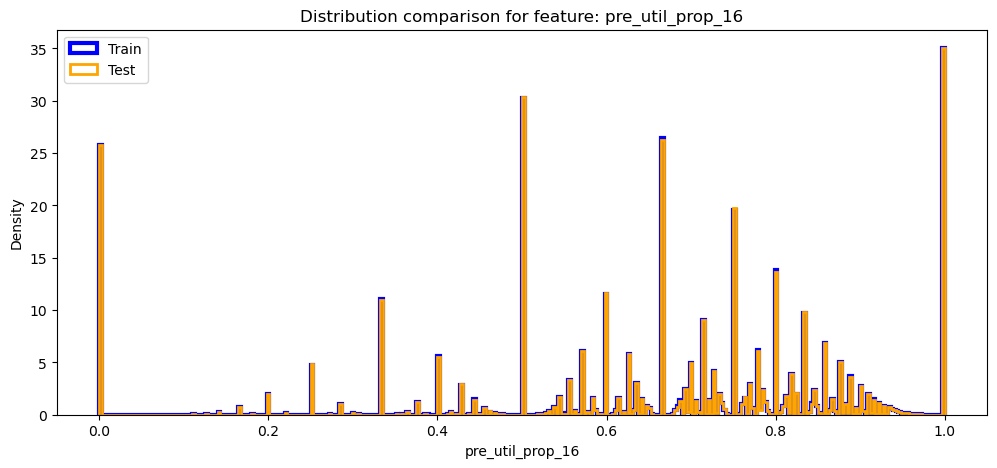

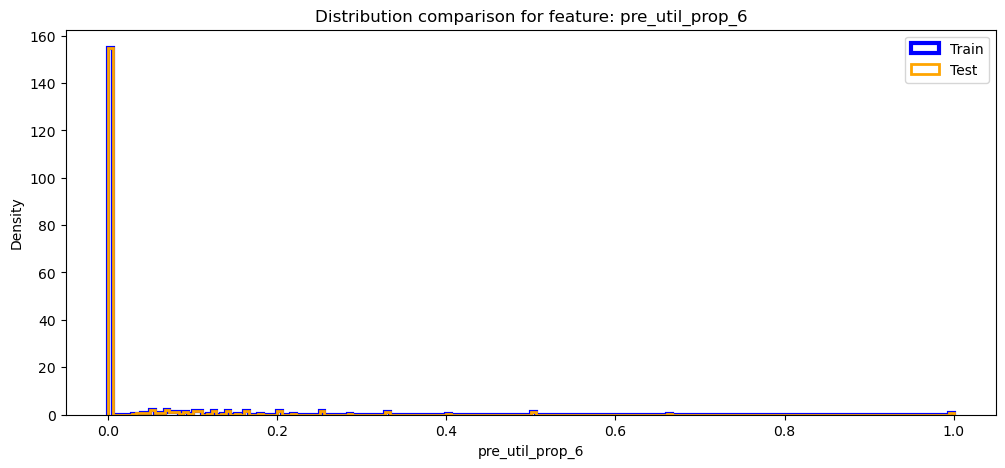

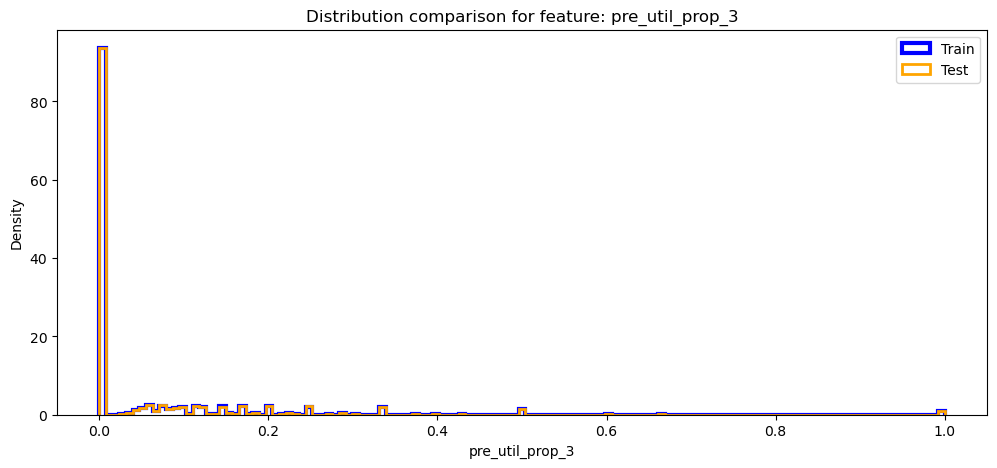

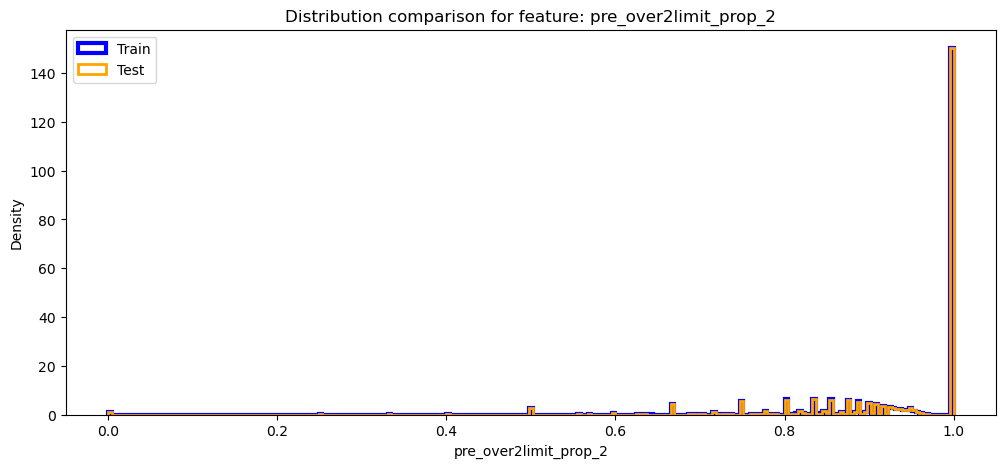

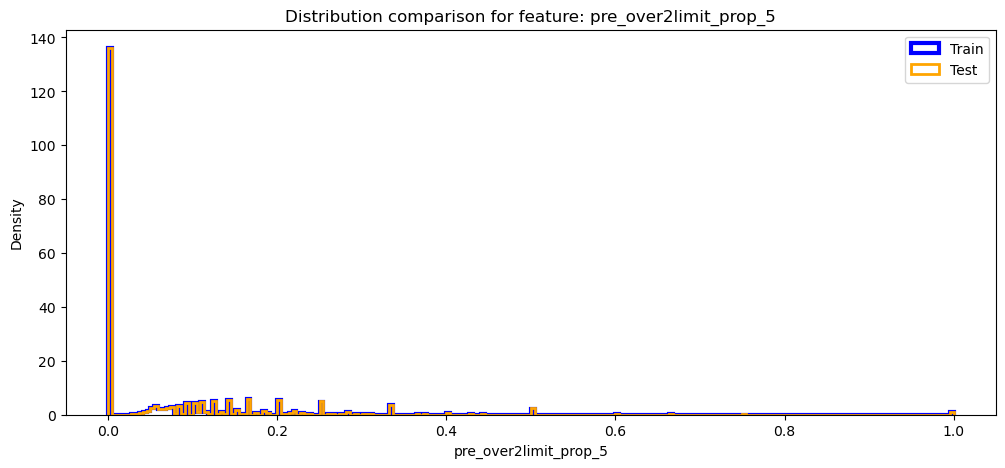

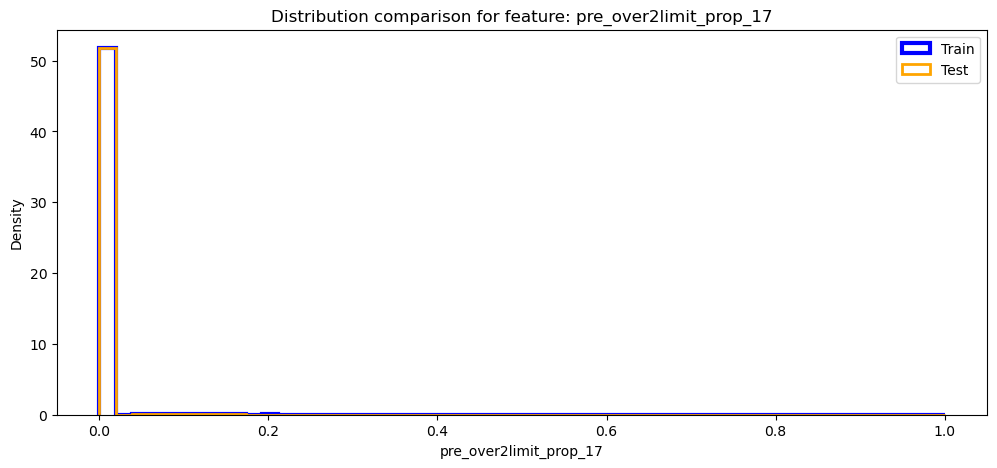

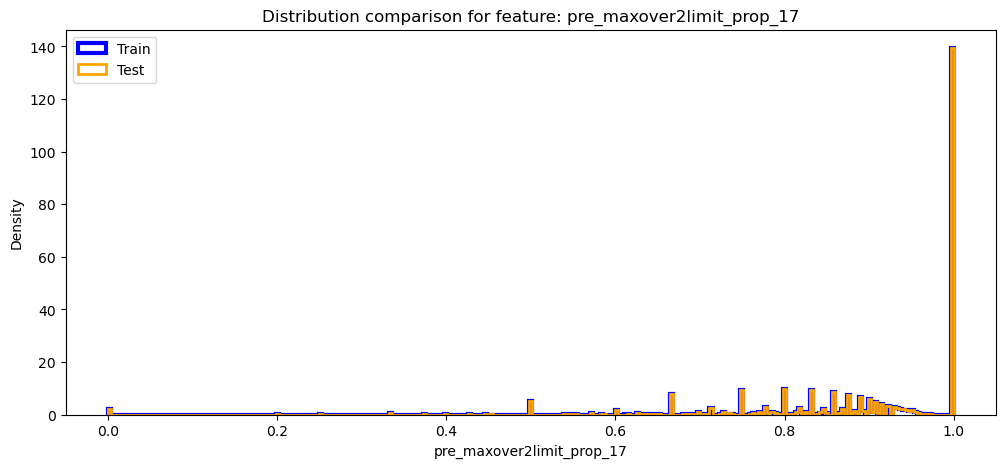

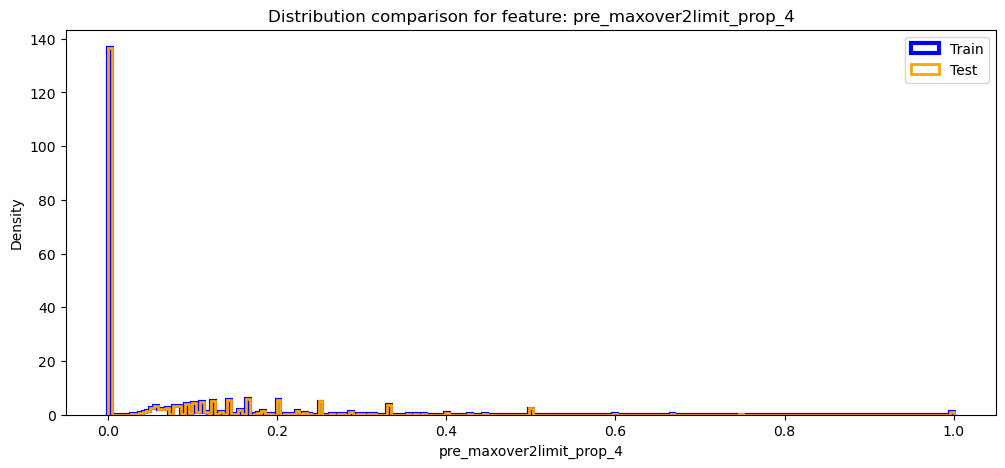

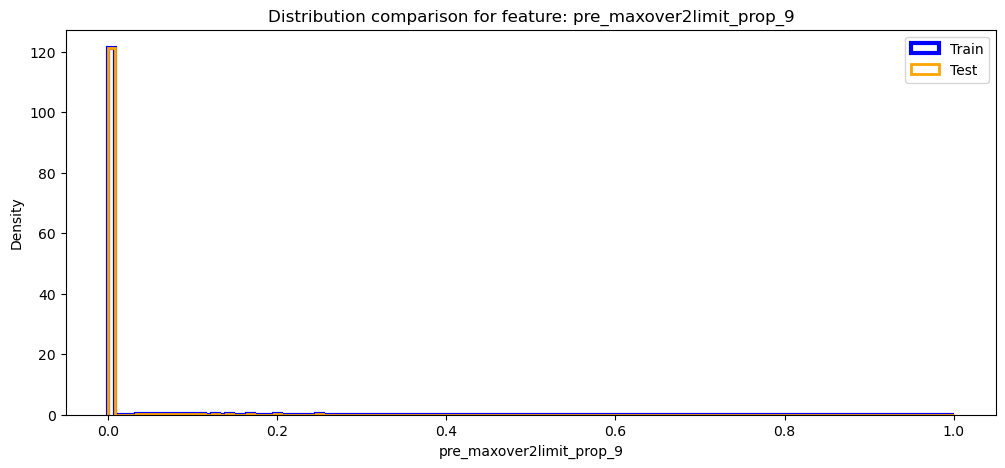

In [48]:
# Визуально сравним распределения признаков для тренировочного и тестового датасетов
columns = df_train.columns[3:]
for col in columns:
    plt.figure(figsize=(12, 5))
    
    # Выбираем количество бинов как минимальное число уникальных значений в train и test
    bins = min(df_train[col].nunique(), df_test[col].nunique())
    
    # Строим нормализованные гистограммы для тренировочного и тестового наборов
    plt.hist(
        df_train[col],
        bins=bins,
        density=True,
        label='Train',
        color='blue',
        histtype='step',
        linewidth=3
    )
    plt.hist(
        df_test[col],
        bins=bins,
        density=True,
        label='Test',
        color='orange',
        histtype='step',
        linewidth=2
    )

    plt.title(f'Distribution comparison for feature: {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

За исключением pre_loans3060_prop_9 распределения практически совпадают.